In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
import statistics

In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 50
batch_size = 64
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

In [0]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ])
train_val_dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

0it [00:00, ?it/s]

26427392it [00:04, 5832762.71it/s]                              


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 39632.84it/s]                           
0it [00:00, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


4423680it [00:02, 1653279.55it/s]                            
0it [00:00, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


8192it [00:00, 15086.86it/s]            

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


In [0]:
def plot_graph(training_losses,val_losses,epochs,string):
    plt.figure()
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.title(string + 'per epoch')
    plt.xlabel('Epoch')
    plt.ylabel(string)

# Classifier

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(3136, 500)
        self.fc1_drop = nn.Dropout2d(p=0.3)
        self.fc2 = nn.Linear(500,50)
        self.fc2_drop = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(50,10)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x),2))
        x = F.leaky_relu(F.max_pool2d(self.conv2_bn(self.conv2(x)),2))
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
        x = F.leaky_relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [0]:
model1 = Classifier().cuda()
optimizer = optim.Adam(model1.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
training_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    #train
    print("Epoch", epoch)
    model1.train()
    train_epoch_loss = 0
    train_correct = 0
    for index, (images,labels) in enumerate(trainloader):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        class_train_output = model1(images)
        loss = criterion(class_train_output,labels)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = class_train_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))
    
    #validate
    model1.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(), labels.cuda()
            class_val_output = model1(images)
            loss = criterion(class_val_output,labels)
            val_epoch_loss += loss.item()
            pred = class_val_output.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 0.9006, Training Accuracy: 32350/48000 (67%)
Average validation loss: 0.4892, Testing Accuracy: 9867/12000 (82%)
Epoch 1
Average training loss: 0.5142, Training Accuracy: 39246/48000 (82%)
Average validation loss: 0.3808, Testing Accuracy: 10357/12000 (86%)
Epoch 2
Average training loss: 0.4308, Training Accuracy: 40809/48000 (85%)
Average validation loss: 0.3657, Testing Accuracy: 10464/12000 (87%)
Epoch 3
Average training loss: 0.3951, Training Accuracy: 41391/48000 (86%)
Average validation loss: 0.3420, Testing Accuracy: 10519/12000 (88%)
Epoch 4
Average training loss: 0.3798, Training Accuracy: 41822/48000 (87%)
Average validation loss: 0.3092, Testing Accuracy: 10656/12000 (89%)
Epoch 5
Average training loss: 0.3585, Training Accuracy: 42097/48000 (88%)
Average validation loss: 0.3300, Testing Accuracy: 10555/12000 (88%)
Epoch 6
Average training loss: 0.3517, Training Accuracy: 42261/48000 (88%)
Average validation loss: 0.3397, Testing Accuracy: 1064

Lowest validation loss 0.2761695469392741
Lowest training loss 0.25753320414821307
Average test loss: 0.3747, Testing Accuracy: 9041/10000 (90%)


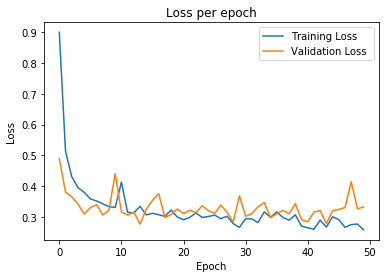

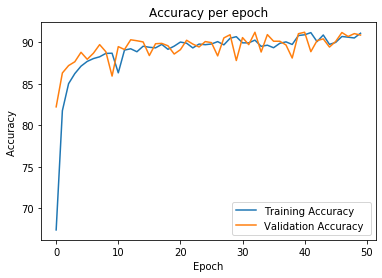

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
print("Lowest validation loss", min(val_losses))
print("Lowest training loss", min(training_losses))
model1.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
  for images, labels in testloader:
    images, labels = images.cuda(), labels.cuda()
    class_test_output = model1(images)
    loss = criterion(class_test_output,labels)
    test_epoch_loss += loss.item()
    pred = class_test_output.max(1, keepdim=True)[1] # get the index of the max log-probability
    test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average test loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
    test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

# Autoencoder

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)

        self.deconv1 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2)
        self.deconv2 = nn.ConvTranspose2d(32,1,kernel_size=2,stride=2)
  
    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x),2))
        encoded = F.leaky_relu(F.max_pool2d(self.conv2_bn(self.conv2(x)),2))
        decoded = F.leaky_relu(self.deconv1(encoded))
        decoded = self.deconv2(decoded)
        return torch.sigmoid(decoded)

In [0]:
model2 = AutoEncoder().cuda()
optimizer = optim.Adam(model2.parameters(),lr=0.01)
criterion = nn.MSELoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    #train
    print("Epoch", epoch)
    model2.train()
    train_epoch_loss = 0
    for index, (images,labels) in enumerate(trainloader):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        auto_train_output = model2(images)
        loss = criterion(auto_train_output,images)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
    train_epoch_loss /= len(trainloader)
    print("Average training loss:",train_epoch_loss)
    training_losses.append(train_epoch_loss)
    
    #validate
    model2.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(), labels.cuda()
            auto_val_output = model2(images)
            loss = criterion(auto_val_output,images)
            val_epoch_loss += loss.item()
    val_epoch_loss /= len(valloader)
    print('Average testing loss: {:.4f}'.format(val_epoch_loss))
    val_losses.append(val_epoch_loss)

Epoch 0
Average training loss: 0.0064964116951450705
Average testing loss: 0.0046
Epoch 1
Average training loss: 0.0035588888035466273
Average testing loss: 0.0031
Epoch 2
Average training loss: 0.0030838880548253655
Average testing loss: 0.0030
Epoch 3
Average training loss: 0.002866685158573091
Average testing loss: 0.0029
Epoch 4
Average training loss: 0.002762654634658247
Average testing loss: 0.0026
Epoch 5
Average training loss: 0.0026486674177770815
Average testing loss: 0.0025
Epoch 6
Average training loss: 0.002545040330228706
Average testing loss: 0.0025
Epoch 7
Average training loss: 0.0024649565904401242
Average testing loss: 0.0025
Epoch 8
Average training loss: 0.0024371841792017223
Average testing loss: 0.0027
Epoch 9
Average training loss: 0.002364684271781395
Average testing loss: 0.0022
Epoch 10
Average training loss: 0.0023560422126514217
Average testing loss: 0.0024
Epoch 11
Average training loss: 0.0022474948672267297
Average testing loss: 0.0022
Epoch 12
Average t

Average testing loss: 0.0019


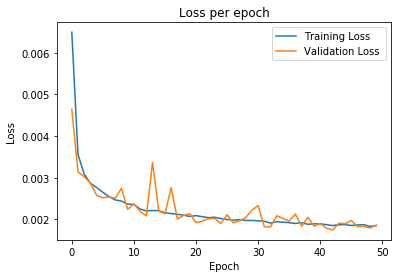

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
model2.eval()
test_epoch_loss = 0
with torch.no_grad():
      for images, labels in testloader:
          images, labels = images.cuda(), labels.cuda()
          auto_test_output = model2(images)
          loss = criterion(auto_test_output,images)
          test_epoch_loss += loss.item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}'.format(test_epoch_loss))

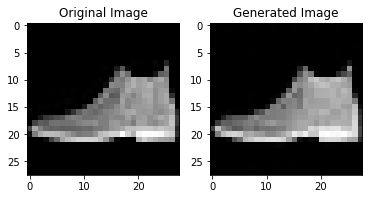

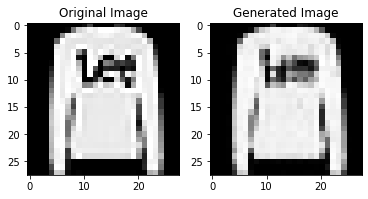

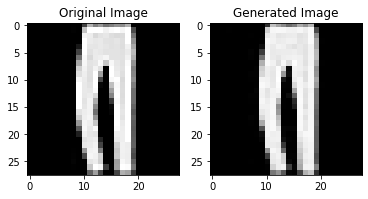

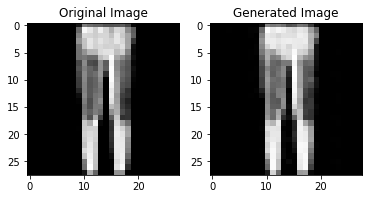

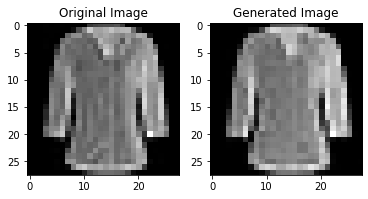

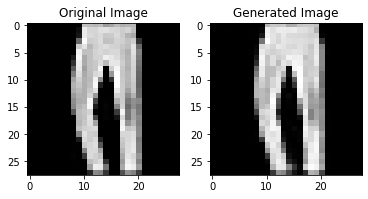

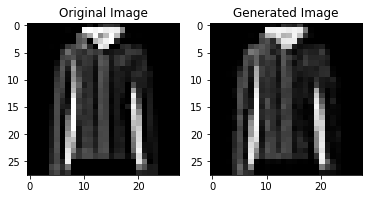

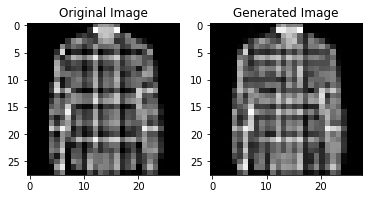

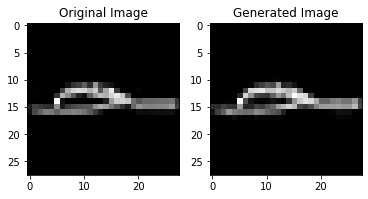

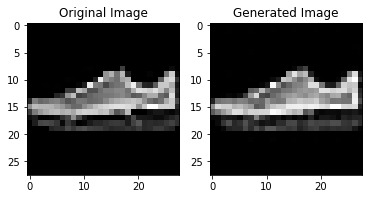

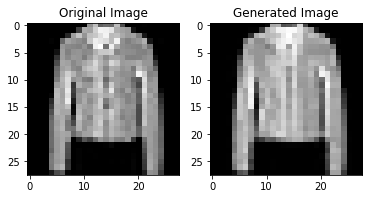

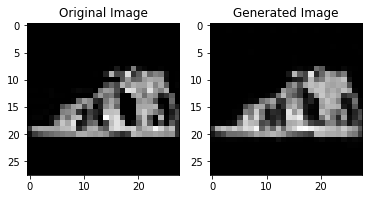

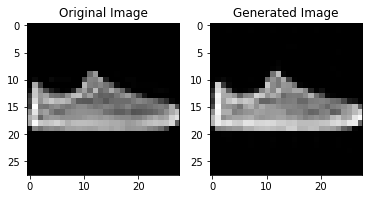

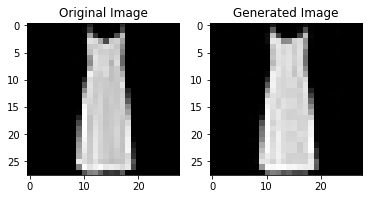

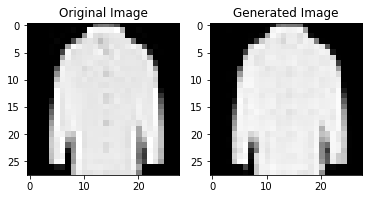

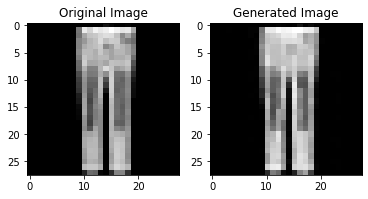

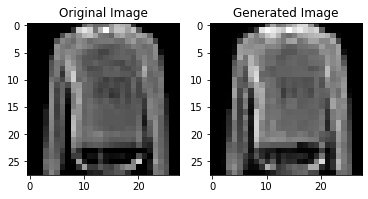

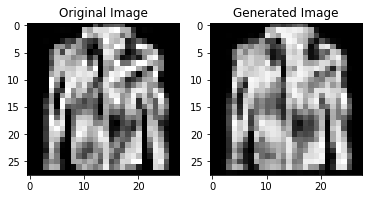

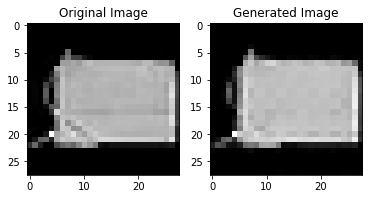

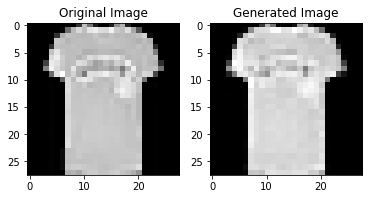

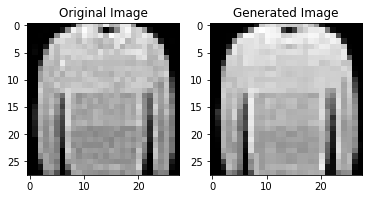

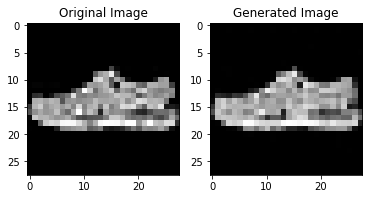

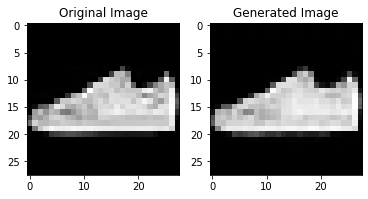

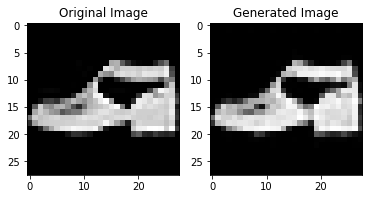

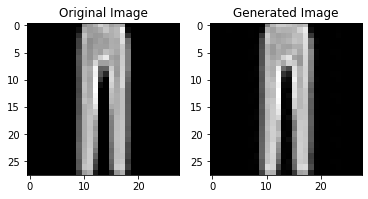

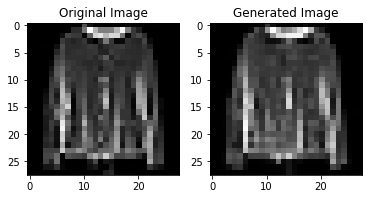

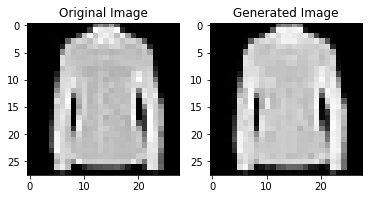

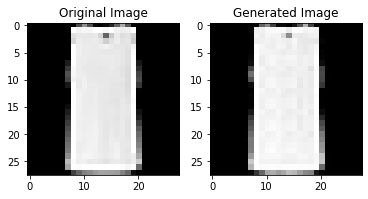

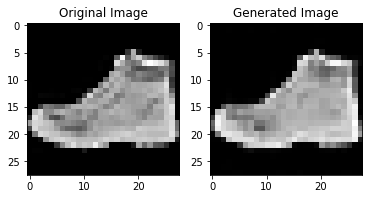

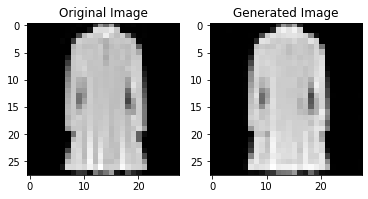

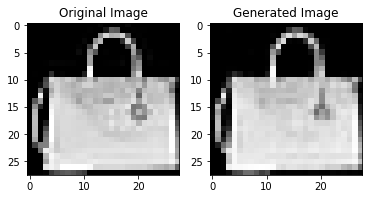

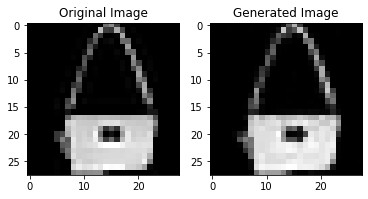

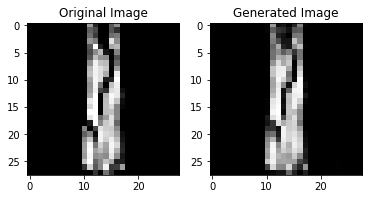

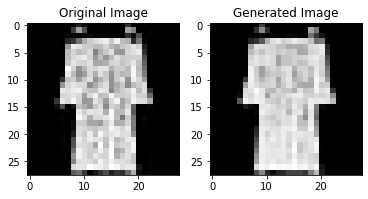

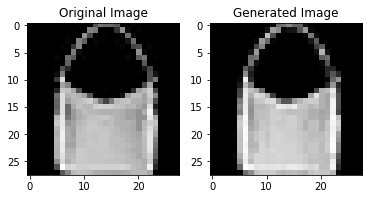

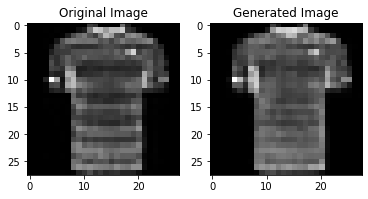

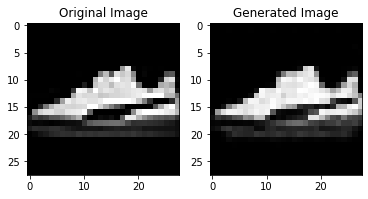

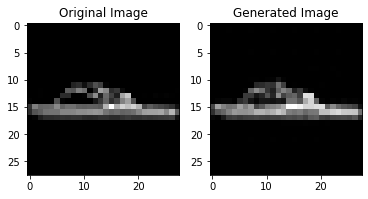

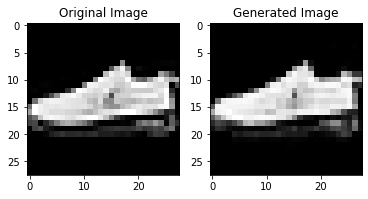

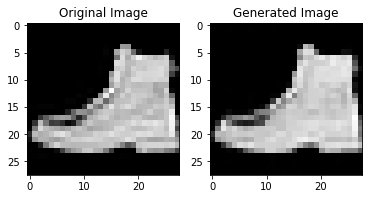

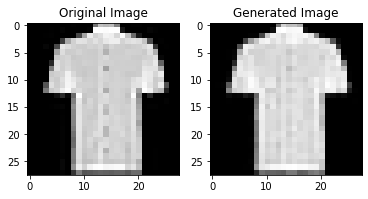

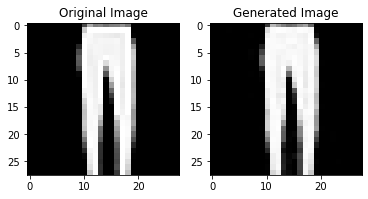

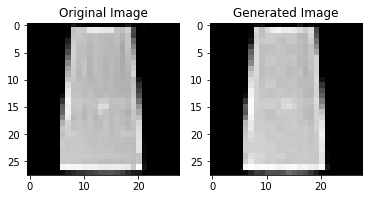

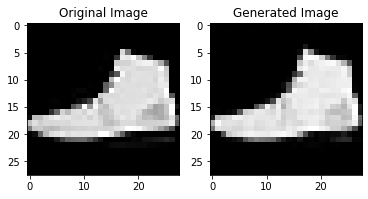

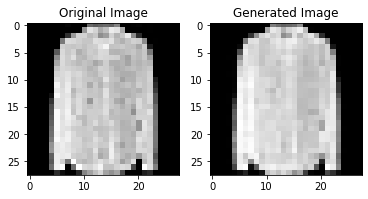

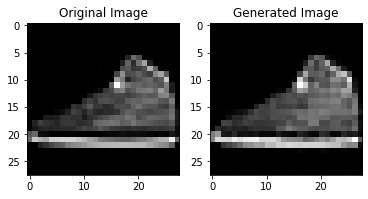

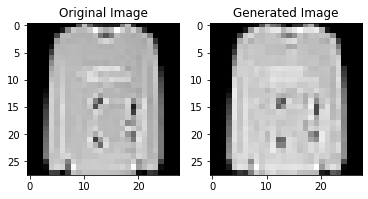

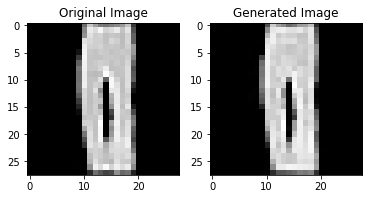

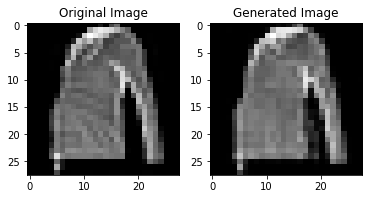

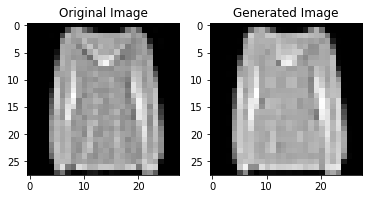

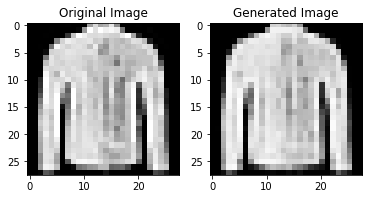

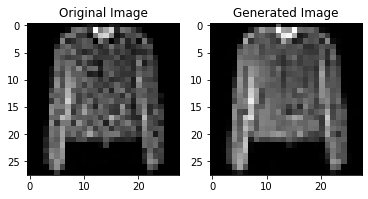

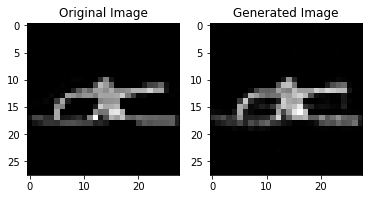

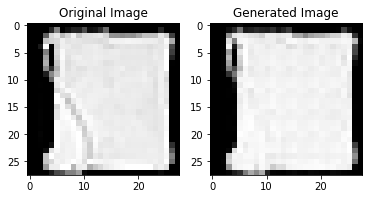

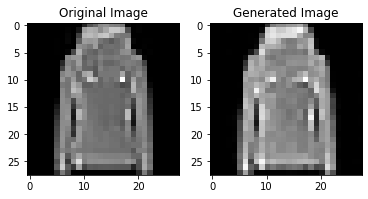

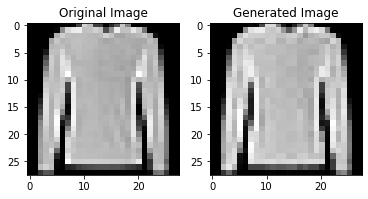

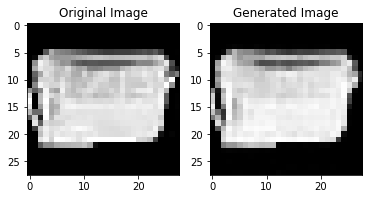

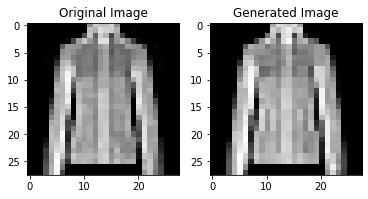

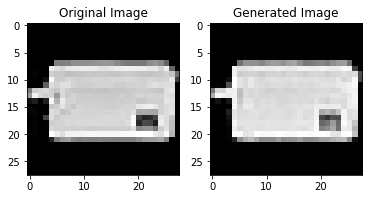

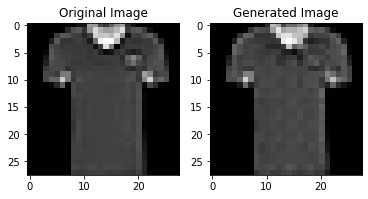

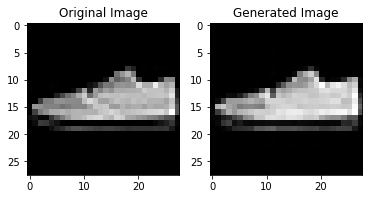

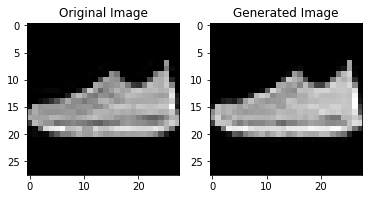

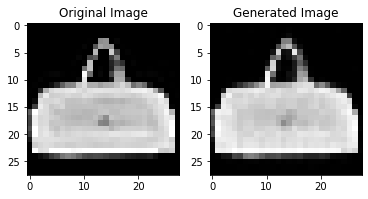

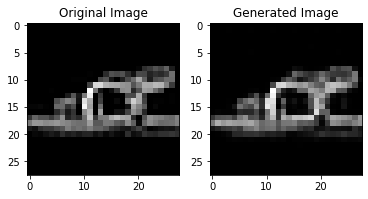

In [0]:
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
test_output = model2(test_images)
#noisy_test_imgs = test_images + 0.1 * torch.randn(*test_images.shape)
#noisy_test_imgs = np.clip(noisy_test_imgs, 0., 1.)
#noisy_test_imgs = noisy_test_imgs.cuda()
#test_output = model(noisy_test_imgs)

inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed model definitions

In [0]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.deconv1 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2)
        self.deconv2 = nn.ConvTranspose2d(32,1,kernel_size=2,stride=2)
        self.fc1 = nn.Linear(3136, 500)
        self.fc1_drop = nn.Dropout2d(p=0.3)
        self.fc2 = nn.Linear(500,50)
        self.fc2_drop = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(50,10)
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        encoded = F.leaky_relu(F.max_pool2d(self.conv2_bn(self.conv2(x)),2))
        decoded = F.leaky_relu(self.deconv1(encoded))
        decoded = self.deconv2(decoded)
        flattened = encoded.view(encoded.size(0),-1)
        predicted = F.leaky_relu(self.fc1_drop(self.fc1(flattened)))
        predicted = F.leaky_relu(self.fc2_drop(self.fc2(predicted)))
        predicted = self.fc3(predicted)
        return torch.sigmoid(decoded), F.log_softmax(predicted, dim=1)

# Mixed (autoencoder loss)

In [0]:
model3 = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model3.parameters(),lr=0.01)
training_losses = []
val_losses = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model3.train()
    train_epoch_loss = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded_auto_train_mixed,predicted = model3(images)
        loss = criterion1(decoded_auto_train_mixed,images)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print("Average training loss:",train_epoch_loss)
    training_losses.append(train_epoch_loss)

    #validate
    model3.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded_auto_val_mixed, predicted = model3(images)
            loss = criterion1(decoded_auto_val_mixed,images)
            val_epoch_loss += loss.item()
    val_epoch_loss /= len(valloader)
    print("Average validation loss:",val_epoch_loss)
    val_losses.append(val_epoch_loss)

Epoch 0
Average training loss: 0.006336485123882691
Average validation loss: 0.0038464934617142253
Epoch 1
Average training loss: 0.00352712259752055
Average validation loss: 0.0025502710647762137
Epoch 2
Average training loss: 0.003131023389597734
Average validation loss: 0.002446829857790169
Epoch 3
Average training loss: 0.0029067996574255327
Average validation loss: 0.002390633193538227
Epoch 4
Average training loss: 0.002734808885026723
Average validation loss: 0.004795573743436724
Epoch 5
Average training loss: 0.002682353924959898
Average validation loss: 0.0026858407605261088
Epoch 6
Average training loss: 0.002601326568207393
Average validation loss: 0.002281395775424515
Epoch 7
Average training loss: 0.0025346961322550974
Average validation loss: 0.0019218552160383934
Epoch 8
Average training loss: 0.0024554120783383646
Average validation loss: 0.0023415127962312485
Epoch 9
Average training loss: 0.002397105360093216
Average validation loss: 0.0018623983320294622
Epoch 10
Ave

Average testing loss: 0.001912491922533721


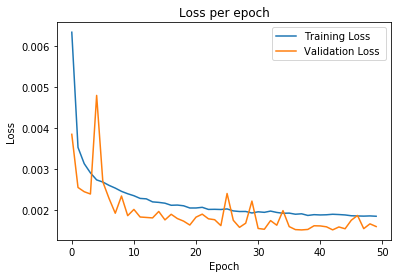

In [0]:
plot_graph(training_losses,val_losses,epochs, "Loss ")
model3.eval()
test_epoch_loss = 0
with torch.no_grad():
    for images, labels in testloader:
          images, labels = images.cuda(),labels.cuda()
          decoded_auto_test_mixed, predicted = model3(images)
          loss = criterion1(decoded_auto_test_mixed,images)
          test_epoch_loss += loss.item()
test_epoch_loss /= len(testloader)
print("Average testing loss:",test_epoch_loss)

In [0]:
train_mean_auto = statistics.mean(training_losses)
val_mean_auto = statistics.mean(val_losses)
train_std_auto = statistics.stdev(training_losses)
val_std_auto = statistics.stdev(val_losses)

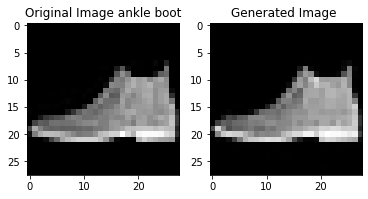

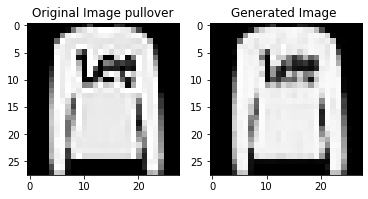

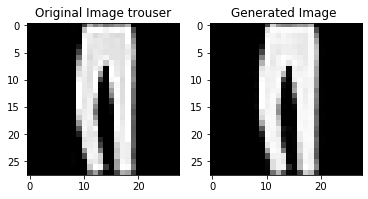

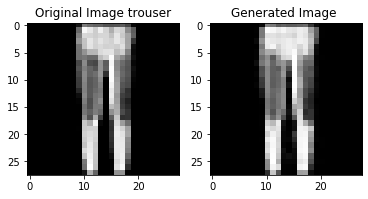

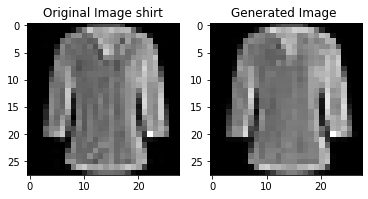

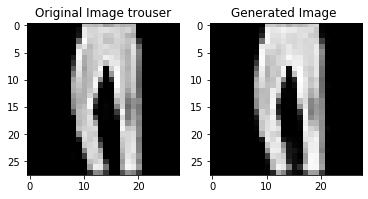

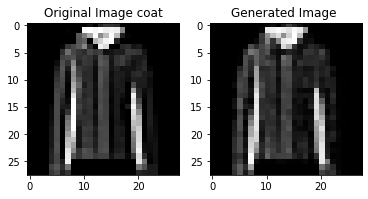

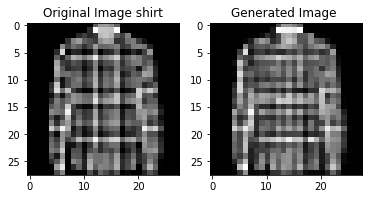

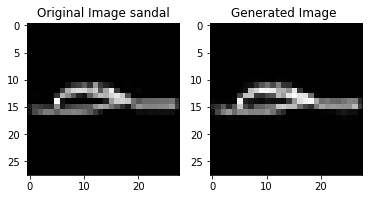

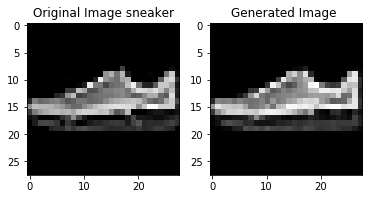

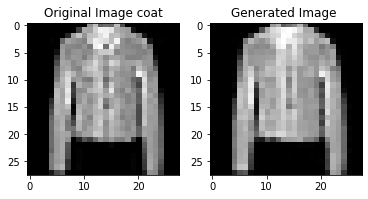

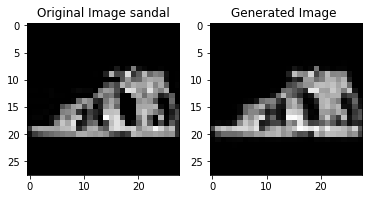

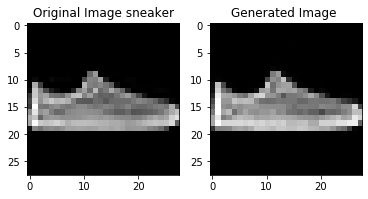

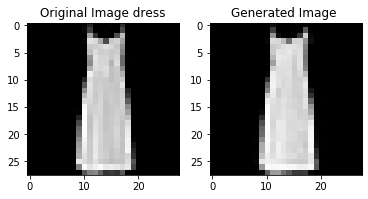

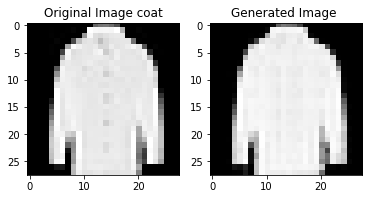

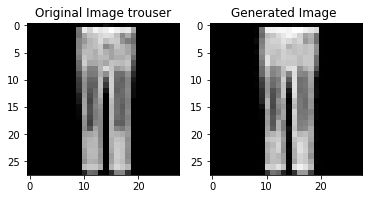

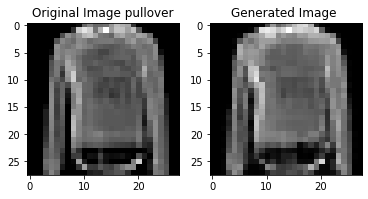

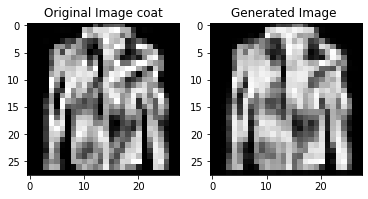

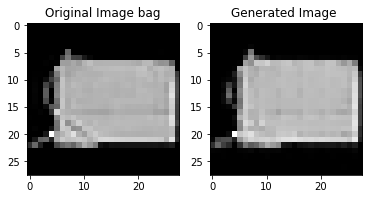

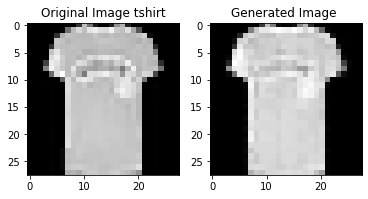

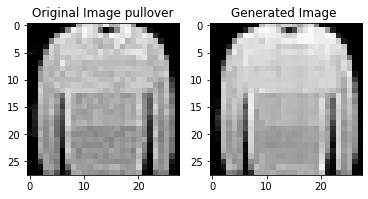

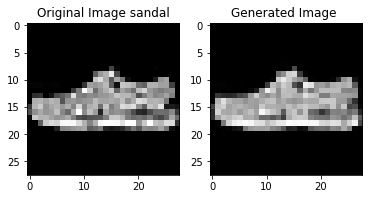

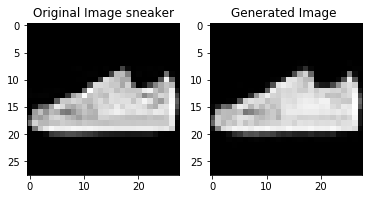

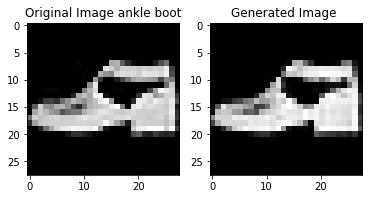

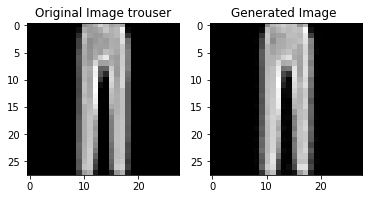

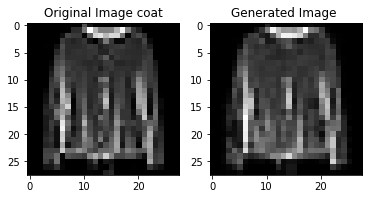

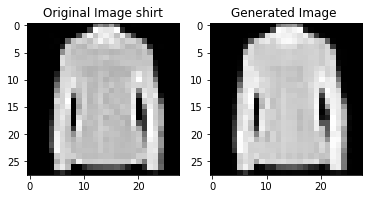

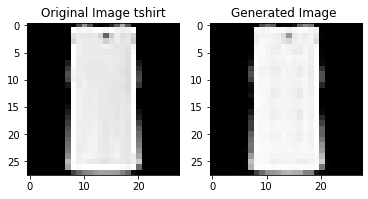

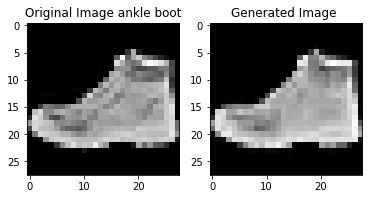

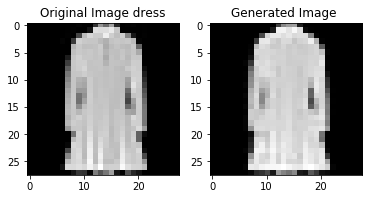

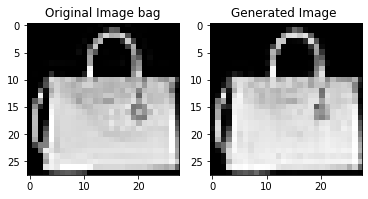

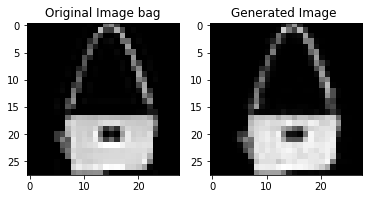

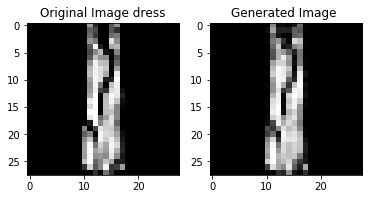

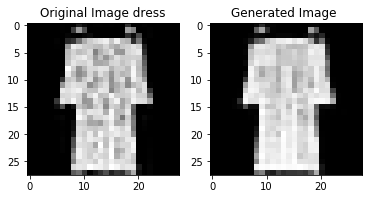

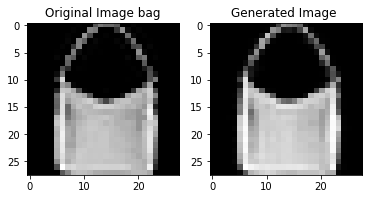

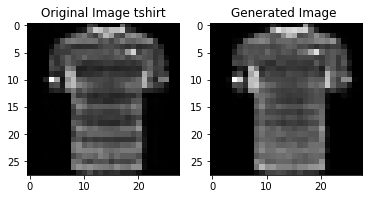

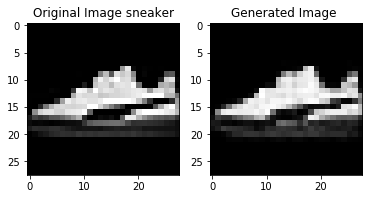

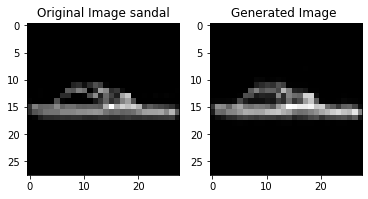

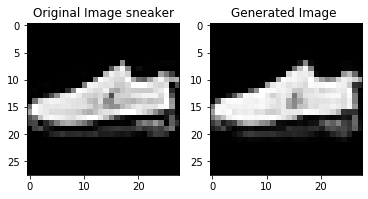

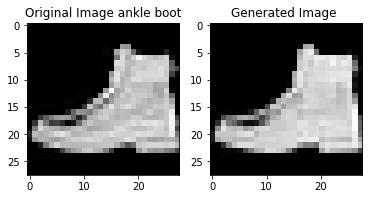

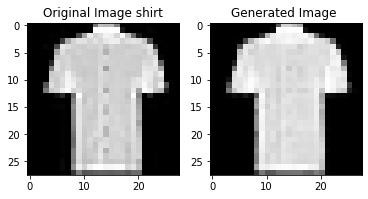

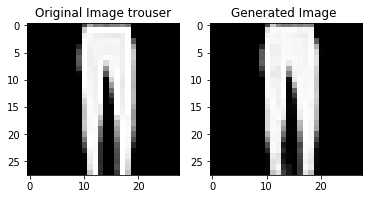

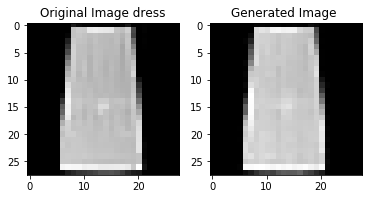

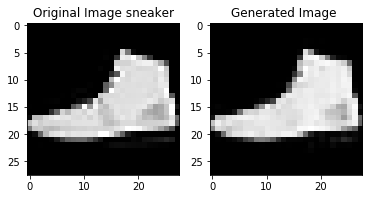

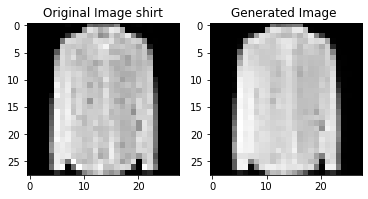

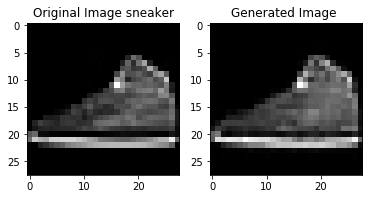

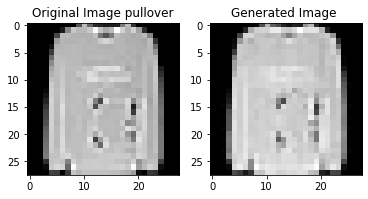

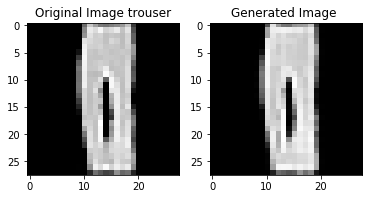

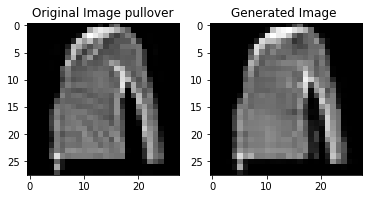

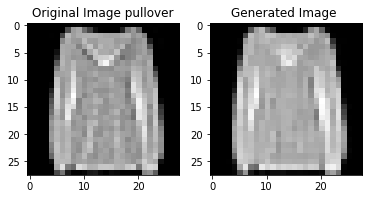

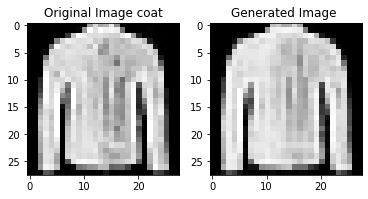

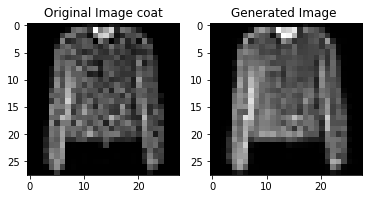

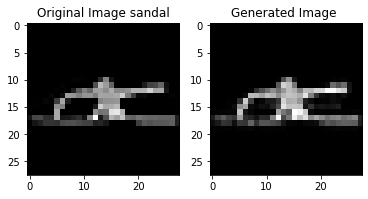

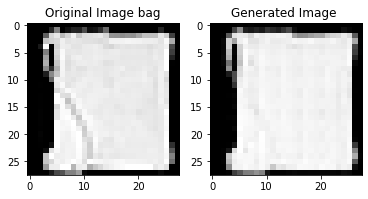

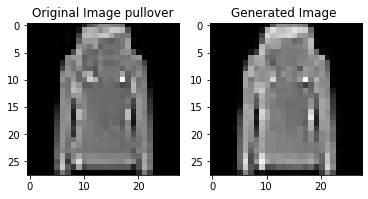

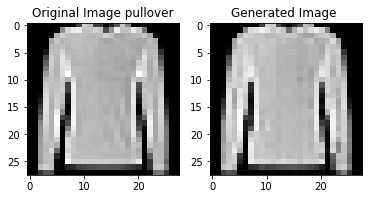

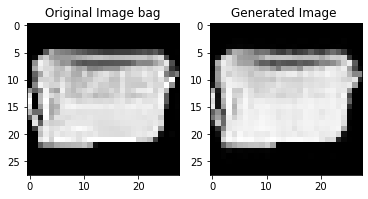

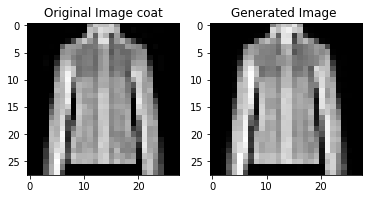

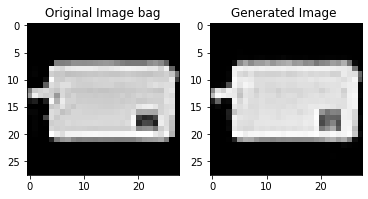

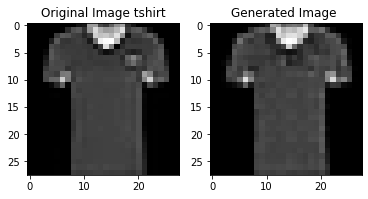

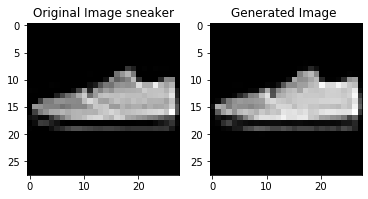

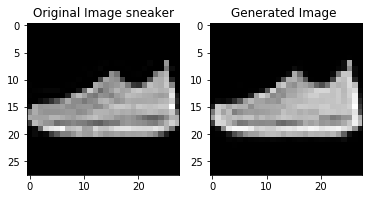

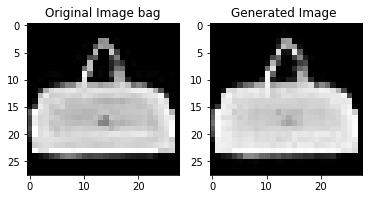

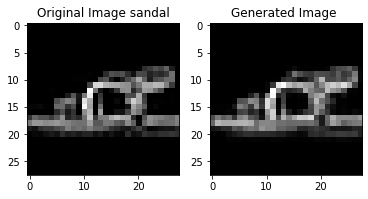

In [0]:
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
test_output, predicted = model3(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed (classifier loss)

In [0]:
model4 = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model4.parameters(),lr=0.01)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model4.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded,predicted = model4(images)
        loss = criterion2(predicted,labels)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model4.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model4(images)
            loss = criterion2(predicted,labels)
            val_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 1.0144, Training Accuracy: 30555/48000 (64%)
Average validation loss: 0.5154, Validation Accuracy: 9666/12000 (81%)
Epoch 1
Average training loss: 0.5349, Training Accuracy: 38770/48000 (81%)
Average validation loss: 0.4146, Validation Accuracy: 10283/12000 (86%)
Epoch 2
Average training loss: 0.4557, Training Accuracy: 40252/48000 (84%)
Average validation loss: 0.3668, Validation Accuracy: 10440/12000 (87%)
Epoch 3
Average training loss: 0.4148, Training Accuracy: 41078/48000 (86%)
Average validation loss: 0.3626, Validation Accuracy: 10478/12000 (87%)
Epoch 4
Average training loss: 0.3869, Training Accuracy: 41487/48000 (86%)
Average validation loss: 0.3215, Validation Accuracy: 10637/12000 (89%)
Epoch 5
Average training loss: 0.3716, Training Accuracy: 41913/48000 (87%)
Average validation loss: 0.3036, Validation Accuracy: 10678/12000 (89%)
Epoch 6
Average training loss: 0.3585, Training Accuracy: 42092/48000 (88%)
Average validation loss: 0.3495, Vali

Average validation loss: 0.3046, Test Accuracy: 9047/10000 (90%)


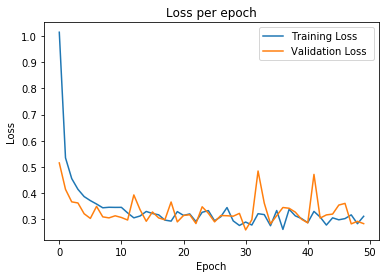

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
model4.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model4(images)
            loss = criterion2(predicted,labels)
            test_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average validation loss: {:.4f}, Test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

In [0]:
train_class_mean = statistics.mean(training_losses)
val_class_mean = statistics.mean(val_losses)
train_class_std = statistics.stdev(training_losses)
val_class_std = statistics.stdev(val_losses)

# Mixed (two losses - no scaling of losses, no feedback)

In [0]:
model5 = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model5.parameters(),lr=0.01)
training_losses = []
val_losses = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model5.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded_train_mixed,predicted = model5(images)
        loss1 = criterion1(decoded_train_mixed,images)
        loss2 = criterion2(predicted,labels)
        loss = loss1+loss2
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)

    #validate
    model5.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            decoded_val_mixed, predicted = model5(images)
            loss1 = criterion1(decoded_val_mixed,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            val_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)

Epoch 0
Average training loss: 1.0759, Training Accuracy: 29394/48000 (61%)
Average validation loss: 0.5500, Validation Accuracy: 9574/12000 (80%)
Epoch 1
Average training loss: 0.5767, Training Accuracy: 38242/48000 (80%)
Average validation loss: 0.4422, Validation Accuracy: 10125/12000 (84%)
Epoch 2
Average training loss: 0.4847, Training Accuracy: 39970/48000 (83%)
Average validation loss: 0.3593, Validation Accuracy: 10485/12000 (87%)
Epoch 3
Average training loss: 0.4522, Training Accuracy: 40764/48000 (85%)
Average validation loss: 0.3629, Validation Accuracy: 10550/12000 (88%)
Epoch 4
Average training loss: 0.4201, Training Accuracy: 41357/48000 (86%)
Average validation loss: 0.3594, Validation Accuracy: 10516/12000 (88%)
Epoch 5
Average training loss: 0.3978, Training Accuracy: 41746/48000 (87%)
Average validation loss: 0.3735, Validation Accuracy: 10680/12000 (89%)
Epoch 6
Average training loss: 0.3850, Training Accuracy: 42004/48000 (88%)
Average validation loss: 0.3288, Vali

Average validation loss: 0.3313, Test Accuracy: 9052/10000 (91%)


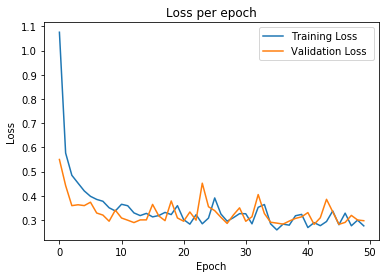

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
#plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model5.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded_test_mixed, predicted = model5(images)
            loss1 = criterion1(decoded_test_mixed,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            test_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average validation loss: {:.4f}, Test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

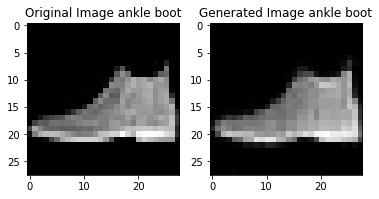

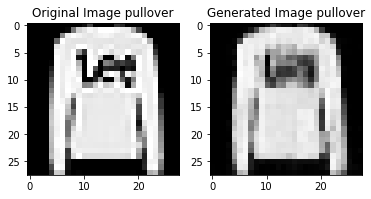

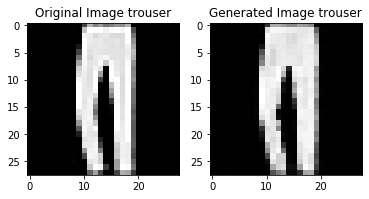

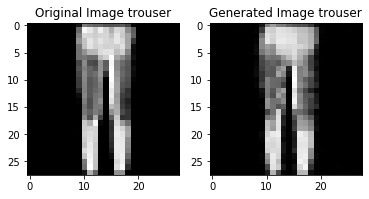

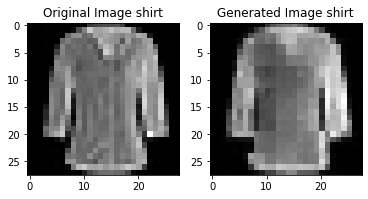

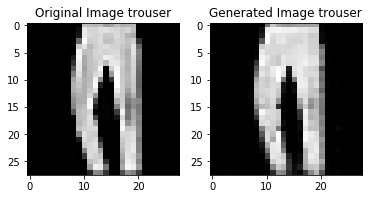

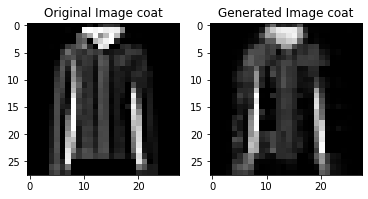

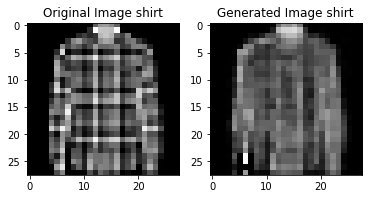

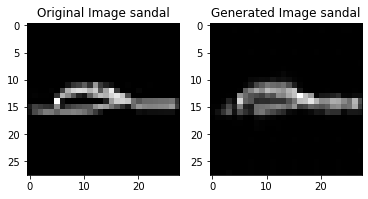

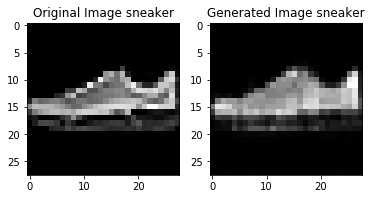

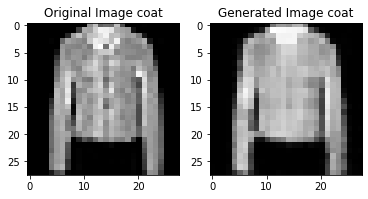

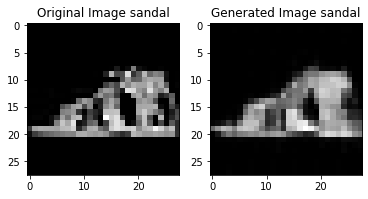

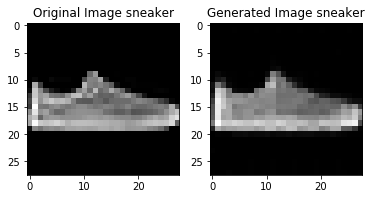

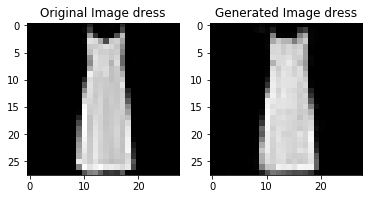

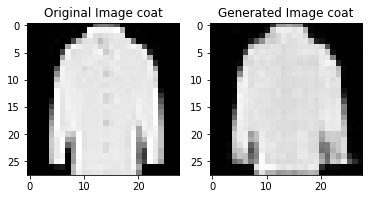

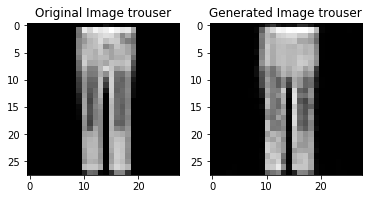

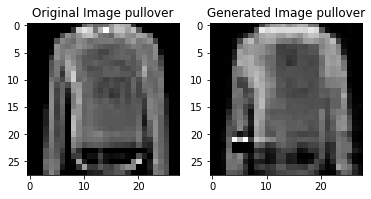

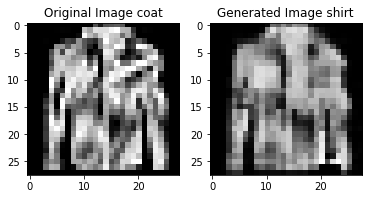

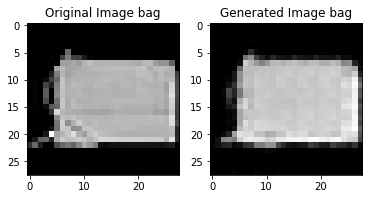

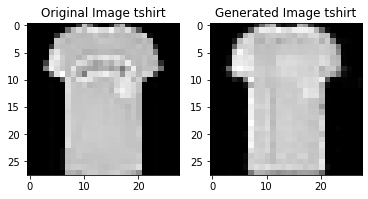

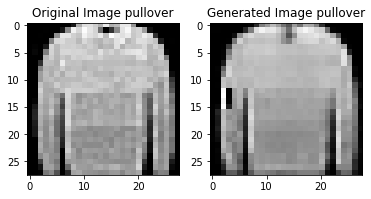

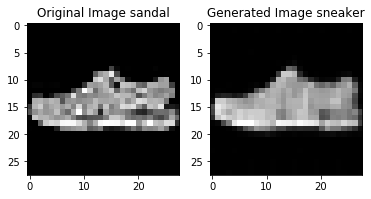

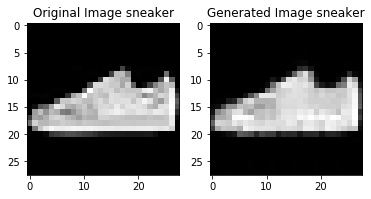

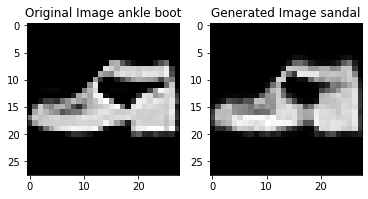

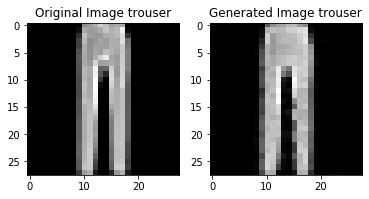

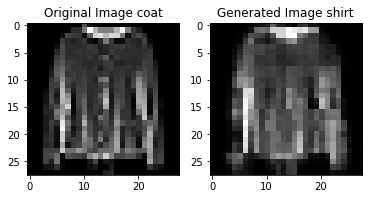

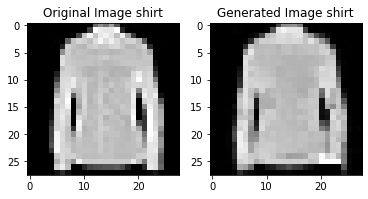

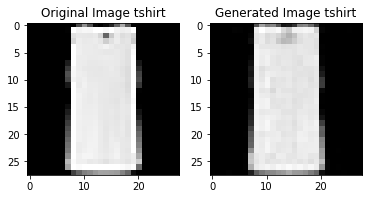

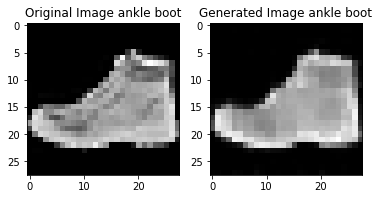

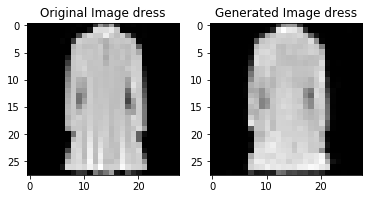

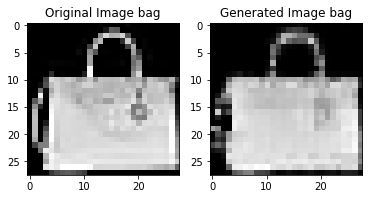

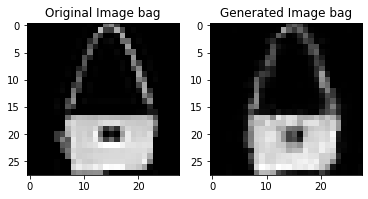

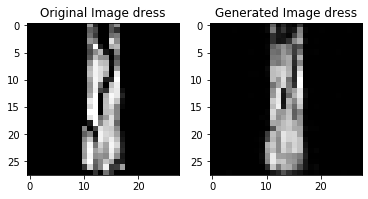

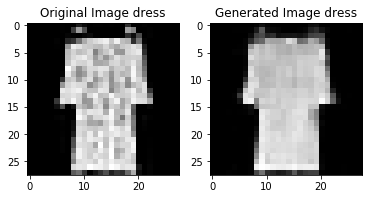

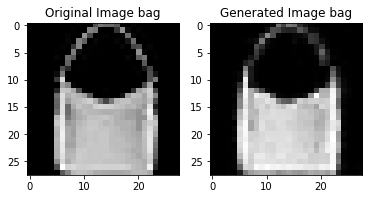

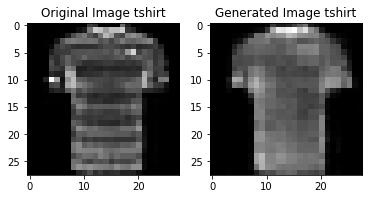

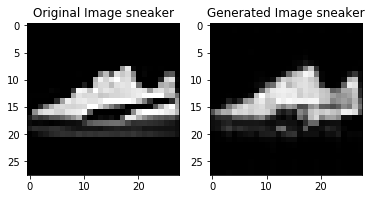

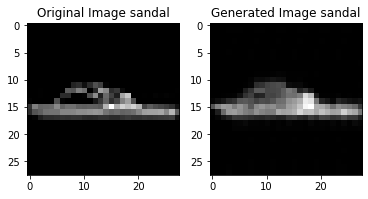

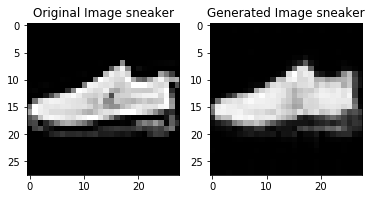

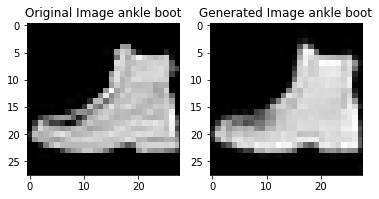

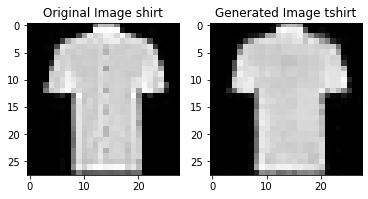

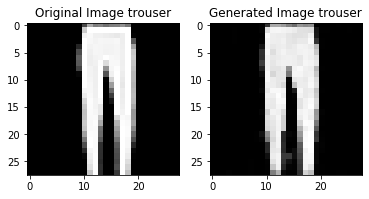

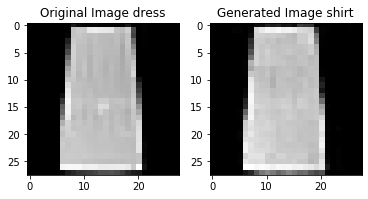

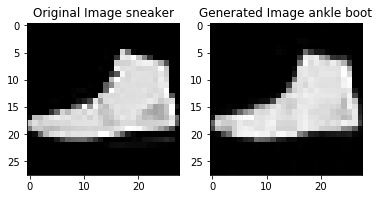

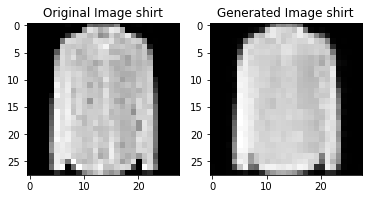

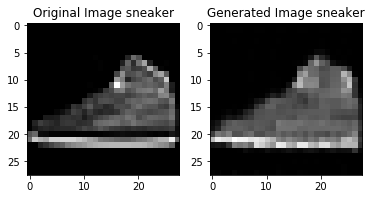

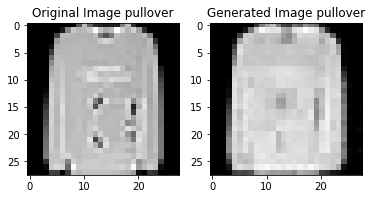

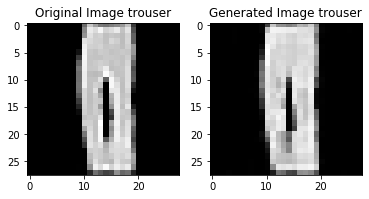

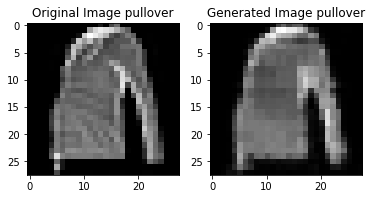

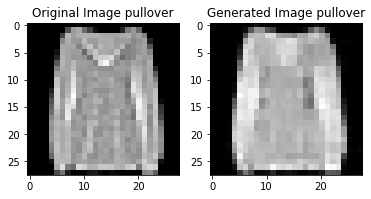

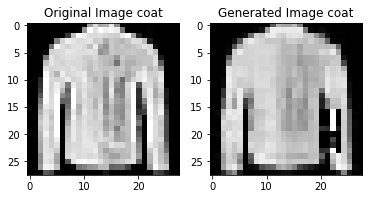

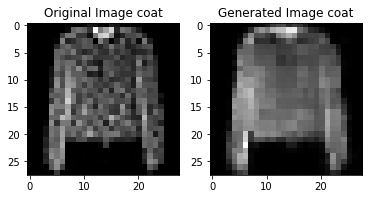

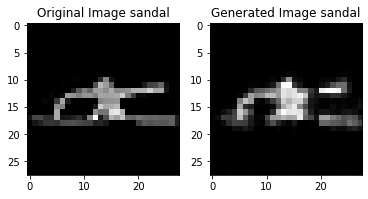

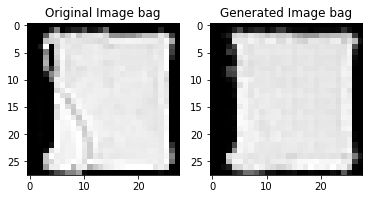

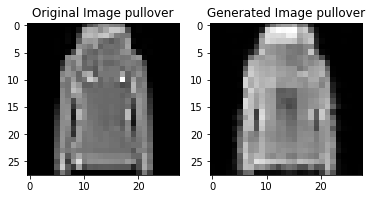

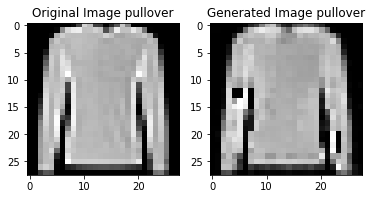

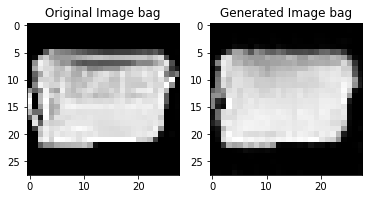

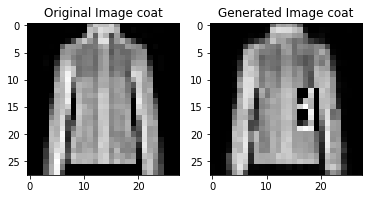

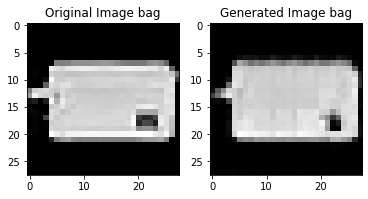

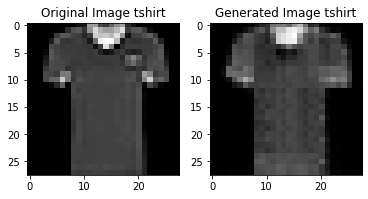

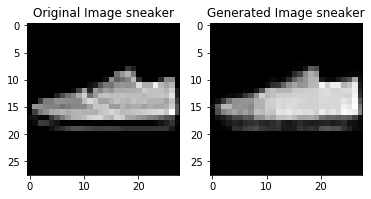

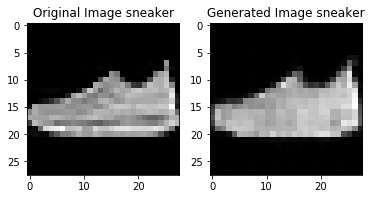

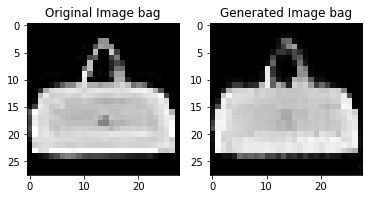

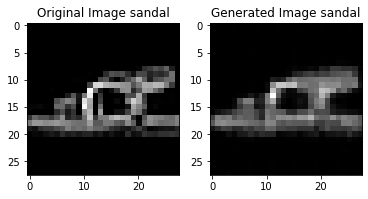

In [0]:
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
test_output, predicted = model5(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed model - with scaling of losses

In [0]:
model7 = Mixed().to(device)
optimizer = optim.Adam(model7.parameters(),lr=0.01)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model7.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded,predicted = model7(images)
        loss1 = (criterion1(decoded,images)-train_mean_auto)/train_std_auto
        loss2 = (criterion2(predicted,labels)-train_class_mean)/train_class_std
        loss = loss1+loss2
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model7.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model7(images)
            loss1 = (criterion1(decoded,images)-val_mean_auto)/val_std_auto
            loss2 = (criterion2(predicted,labels)-val_class_mean)/val_class_std
            loss = loss1+loss2
            val_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 12.9727, Training Accuracy: 31406/48000 (65%)
Average validation loss: 10.7456, Validation Accuracy: 9299/12000 (77%)
Epoch 1
Average training loss: 5.2228, Training Accuracy: 38127/48000 (79%)
Average validation loss: 5.4570, Validation Accuracy: 10168/12000 (85%)
Epoch 2
Average training loss: 3.8651, Training Accuracy: 39748/48000 (83%)
Average validation loss: 3.9633, Validation Accuracy: 10394/12000 (87%)
Epoch 3
Average training loss: 3.1216, Training Accuracy: 40644/48000 (85%)
Average validation loss: 2.6720, Validation Accuracy: 10639/12000 (89%)
Epoch 4
Average training loss: 2.7112, Training Accuracy: 41159/48000 (86%)
Average validation loss: 3.6348, Validation Accuracy: 10708/12000 (89%)
Epoch 5
Average training loss: 2.7051, Training Accuracy: 41148/48000 (86%)
Average validation loss: 3.8597, Validation Accuracy: 10668/12000 (89%)
Epoch 6
Average training loss: 2.0450, Training Accuracy: 41769/48000 (87%)
Average validation loss: 2.6900, Va

Average validation loss: 1.9721, Test Accuracy: 9051/10000 (91%)


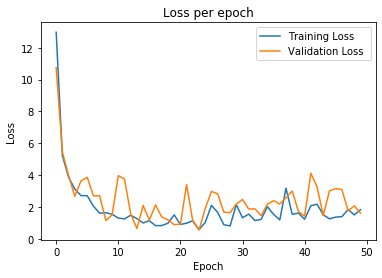

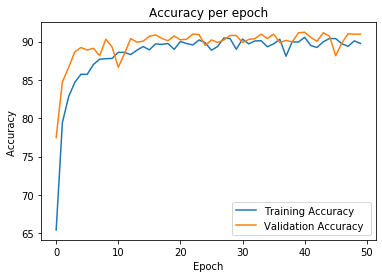

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model7.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model7(images)
            loss1 = (criterion1(decoded,images)-val_mean_auto)/val_std_auto
            loss2 = (criterion2(predicted,labels)-val_class_mean)/val_class_std
            loss = loss1+loss2
            test_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average validation loss: {:.4f}, Test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

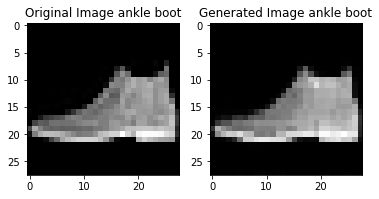

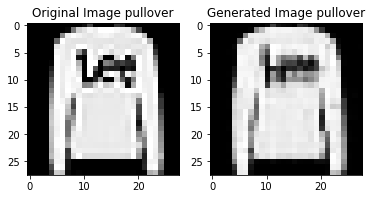

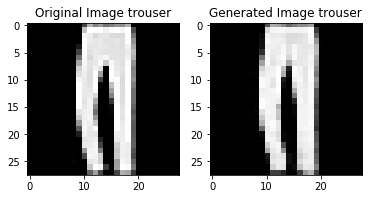

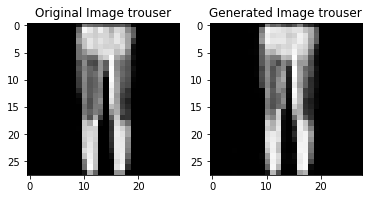

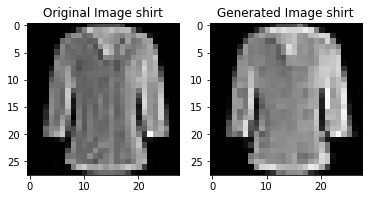

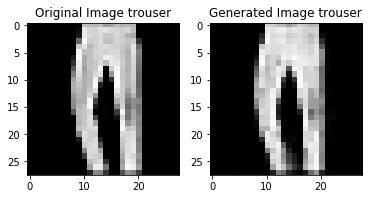

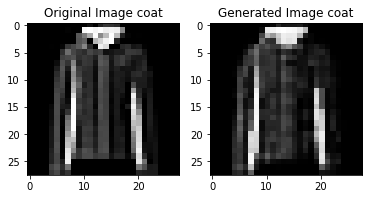

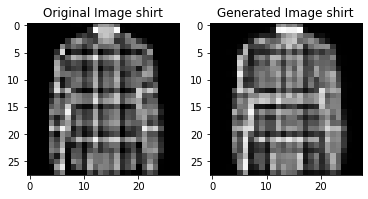

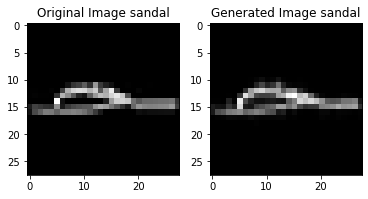

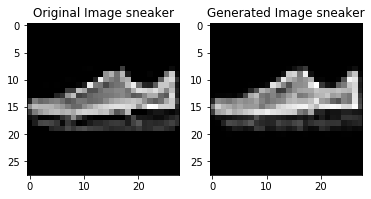

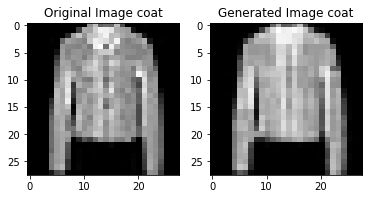

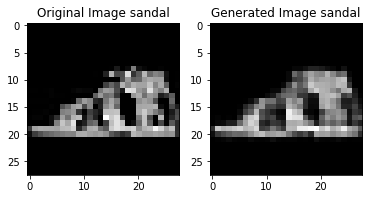

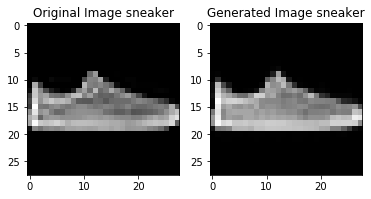

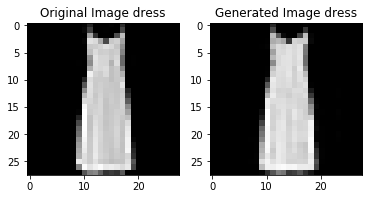

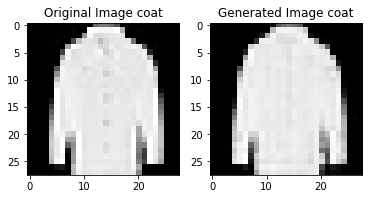

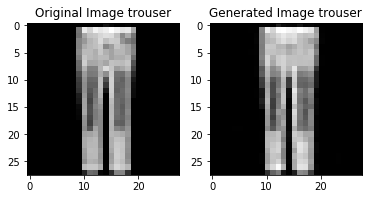

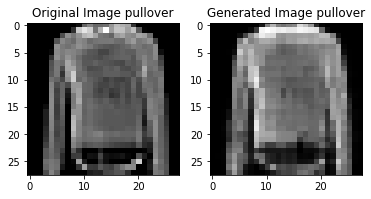

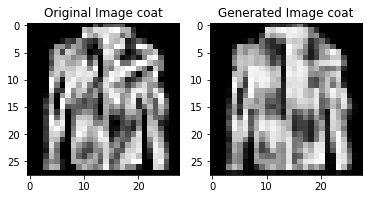

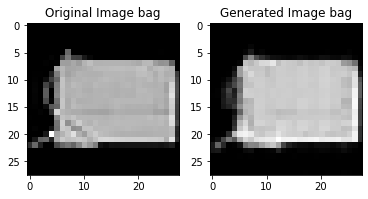

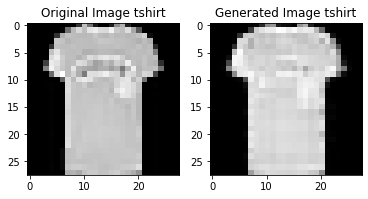

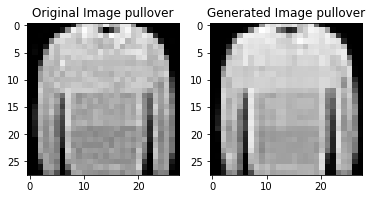

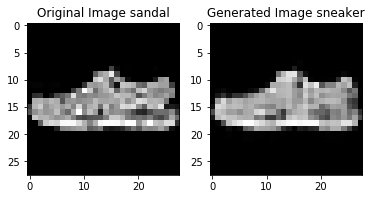

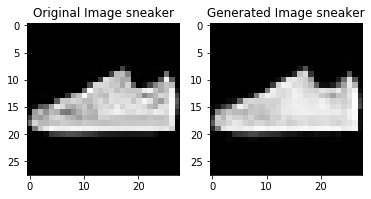

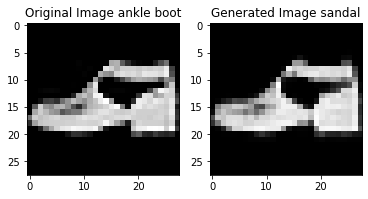

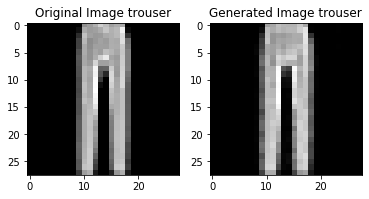

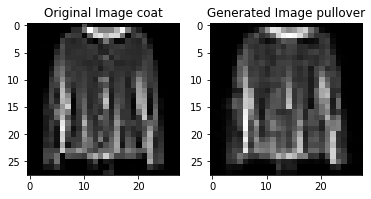

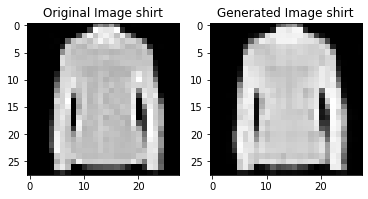

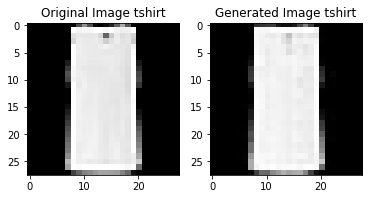

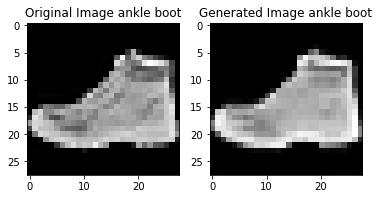

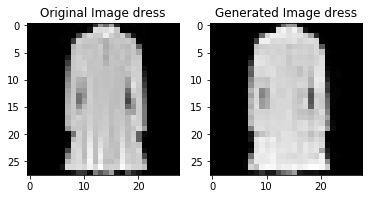

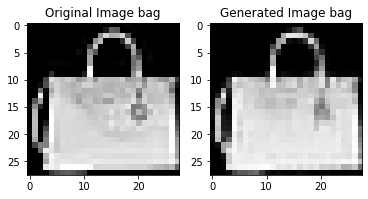

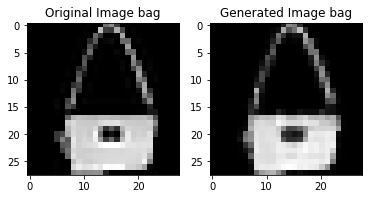

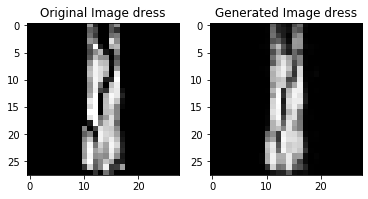

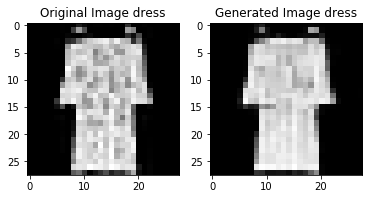

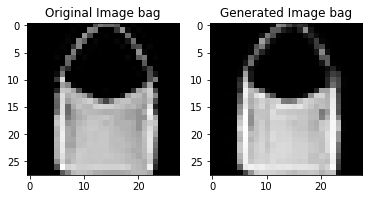

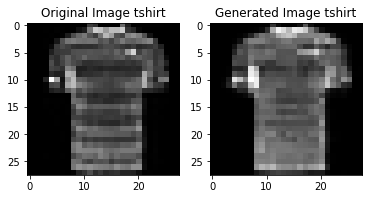

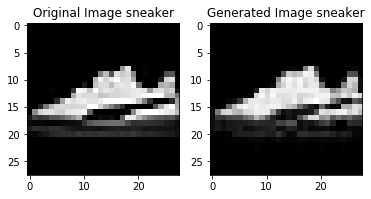

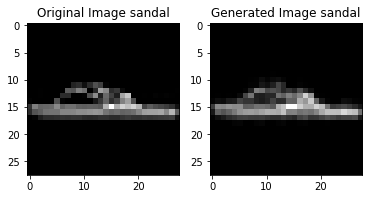

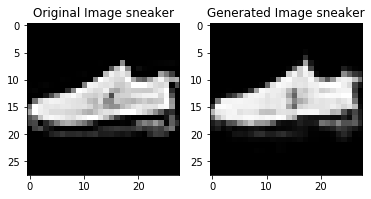

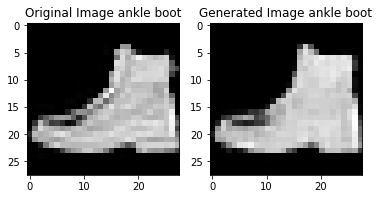

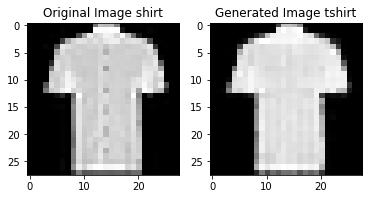

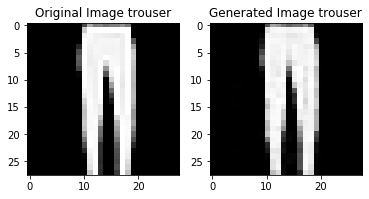

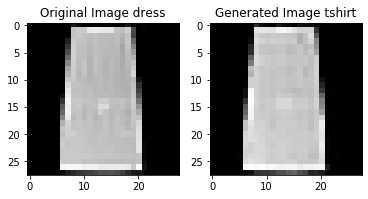

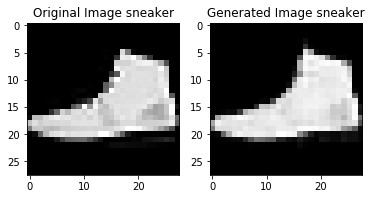

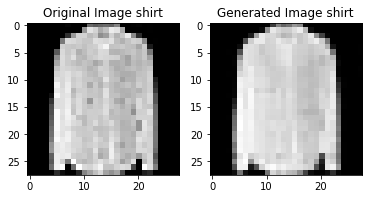

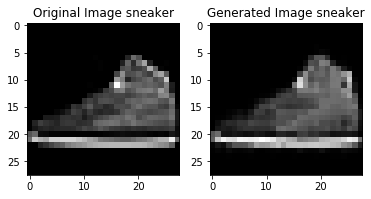

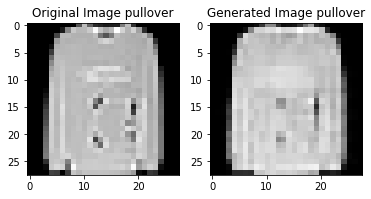

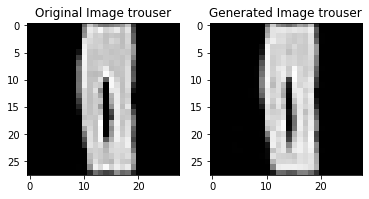

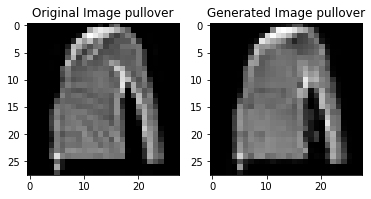

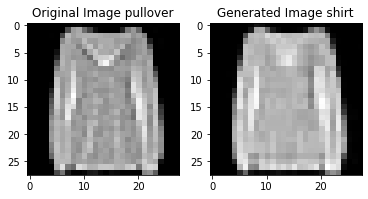

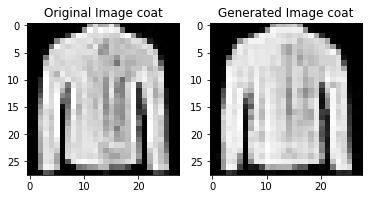

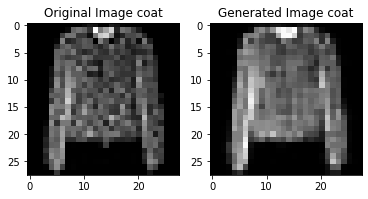

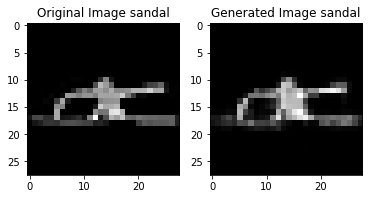

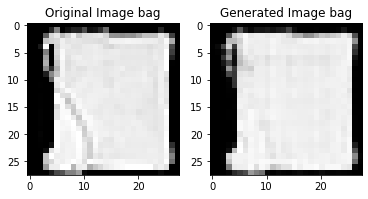

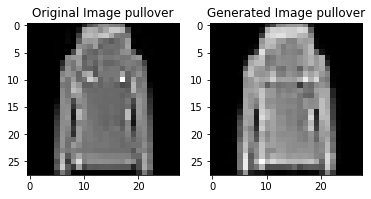

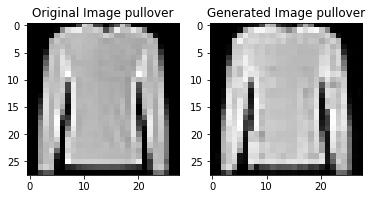

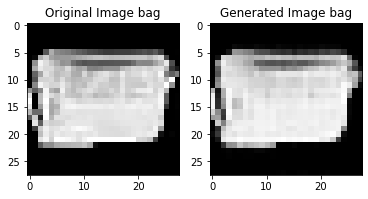

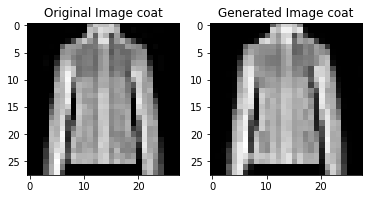

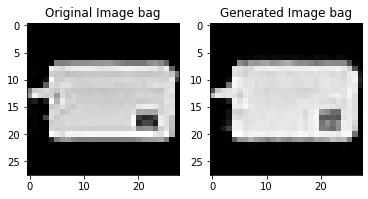

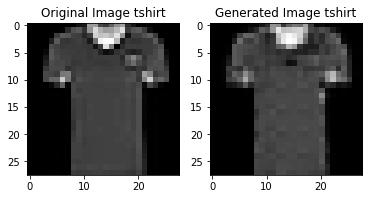

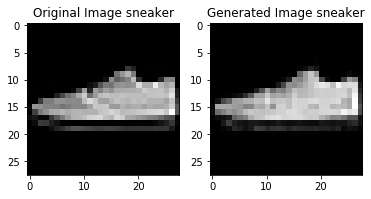

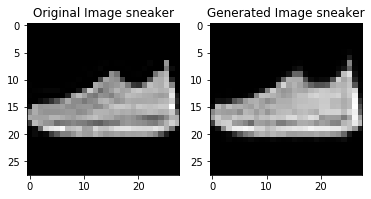

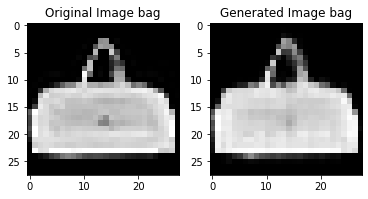

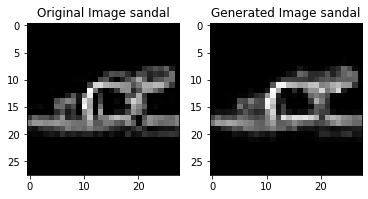

In [0]:
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
test_output, predicted = model7(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed (two losses - no scaling of losses,feedback?)

In [0]:
def subtract(images,generated):
    generated, predicted = model6(images-generated)
    return generated, predicted

In [0]:
#old version which used autoencoder as well
model6 = Mixed().to(device)
#optimizer = optim.SGD(model6.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model6.parameters(),lr=0.01)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model6.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        generated_0,predicted_0 = model6(images) #first pass
        generated_1,predicted_1 = model6(images-generated_0) #feedback loop
        for i in range(3):
          generated_1,predicted_1 = model6(images-generated_1)
          loss1 = criterion1(generated_1,images)
          loss2 = criterion2(predicted_1,labels)
          loss = loss1+loss2*0.7
          loss.backward(retain_graph=True)
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model6.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model6(images) #first pass
            generated_1,predicted_1 = model6(images-generated_0) #feedback loop
            for i in range(3):
                generated_1,predicted_1 = model6(images-generated_1)
                loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss1+loss2*0.7
            val_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 0.6142, Training Accuracy: 34017/48000 (71%)
Average validation loss: 0.3606, Validation Accuracy: 10079/12000 (84%)
Epoch 1
Average training loss: 0.3540, Training Accuracy: 40335/48000 (84%)
Average validation loss: 0.3171, Validation Accuracy: 10353/12000 (86%)
Epoch 2
Average training loss: 0.3070, Training Accuracy: 41607/48000 (87%)
Average validation loss: 0.2601, Validation Accuracy: 10590/12000 (88%)
Epoch 3
Average training loss: 0.2827, Training Accuracy: 42055/48000 (88%)
Average validation loss: 0.2430, Validation Accuracy: 10677/12000 (89%)
Epoch 4
Average training loss: 0.2658, Training Accuracy: 42435/48000 (88%)
Average validation loss: 0.2582, Validation Accuracy: 10683/12000 (89%)
Epoch 5
Average training loss: 0.2568, Training Accuracy: 42696/48000 (89%)
Average validation loss: 0.2352, Validation Accuracy: 10789/12000 (90%)
Epoch 6
Average training loss: 0.2523, Training Accuracy: 42838/48000 (89%)
Average validation loss: 0.2455, Val

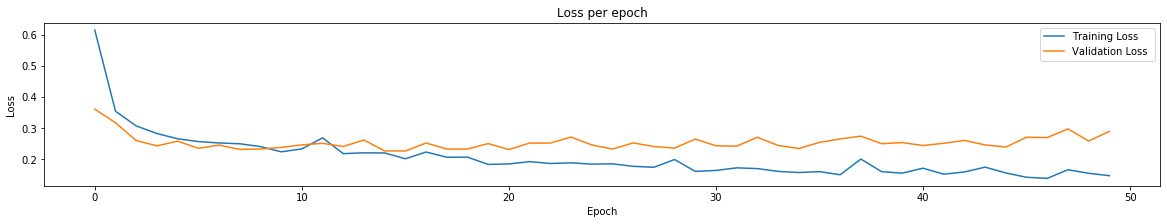

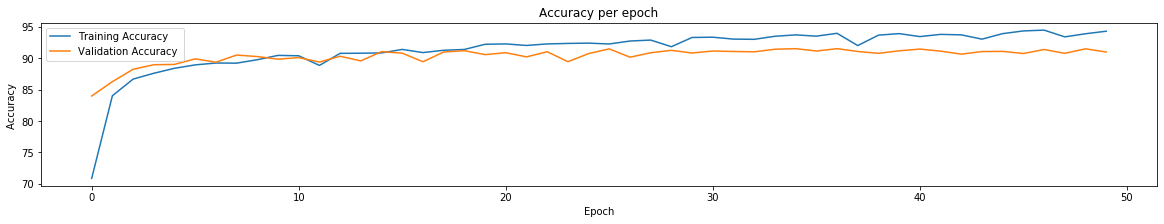

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")

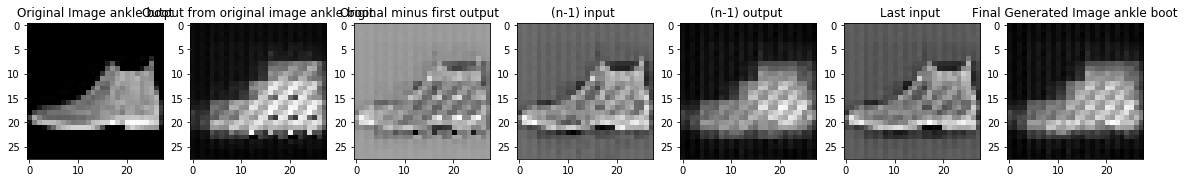

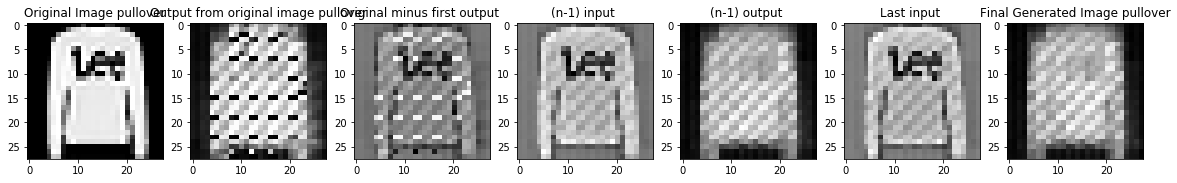

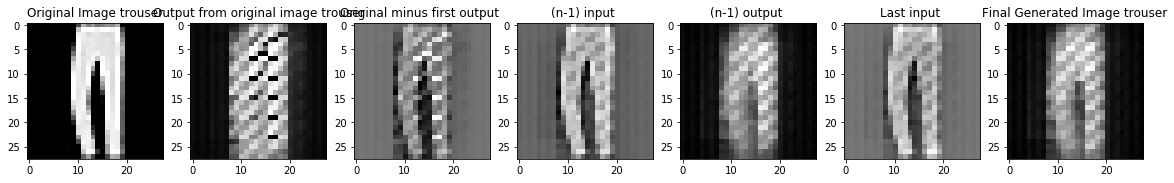

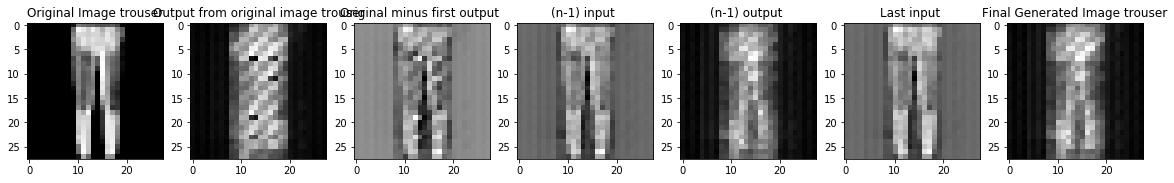

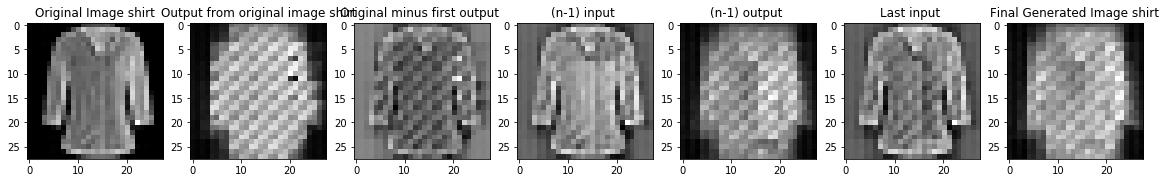

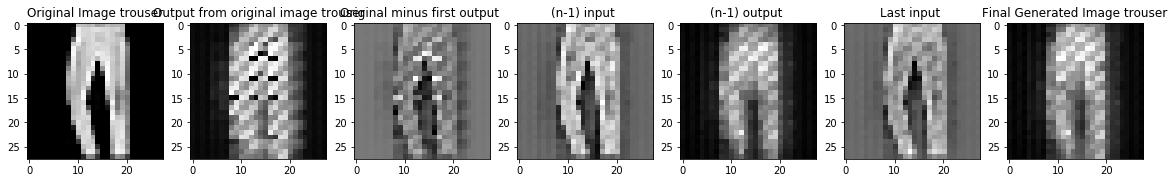

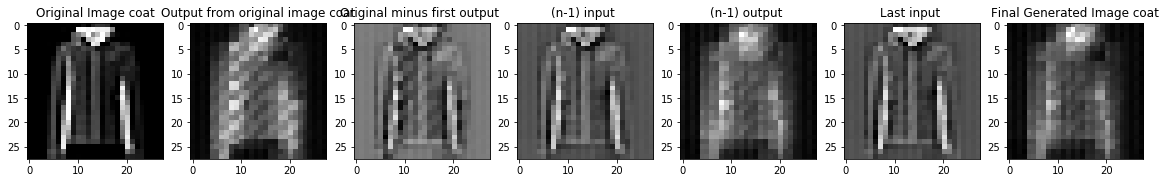

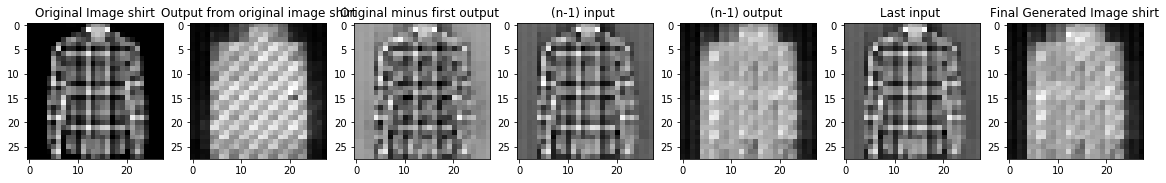

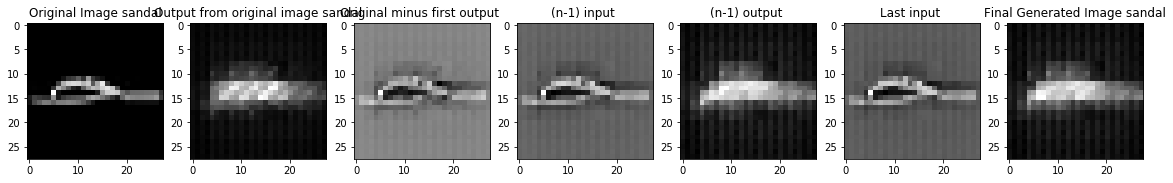

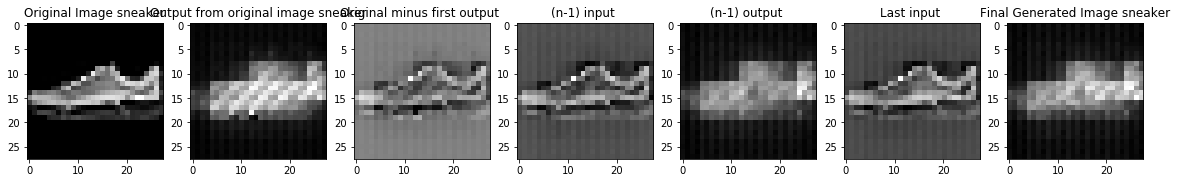

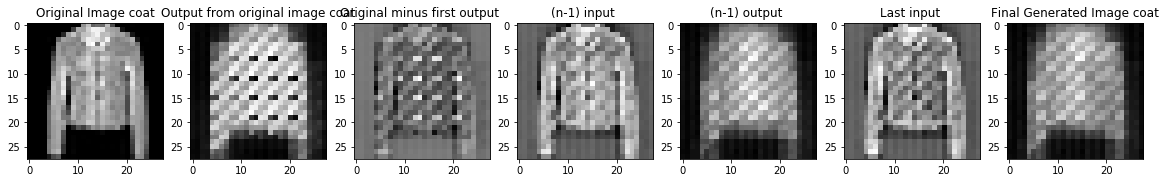

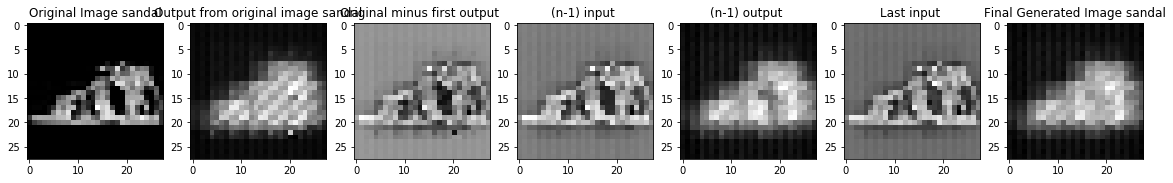

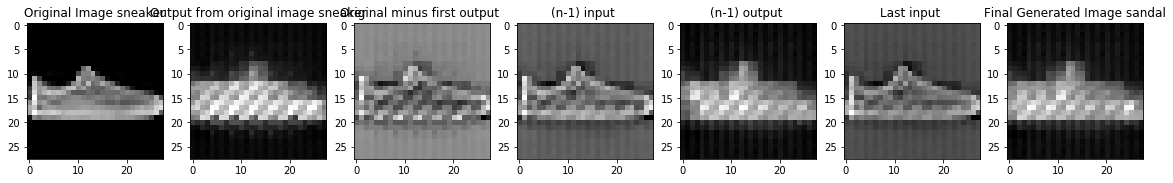

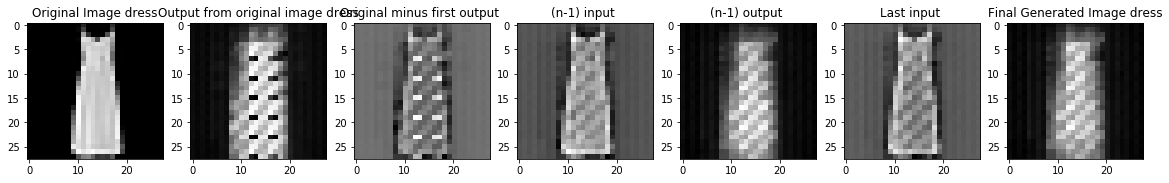

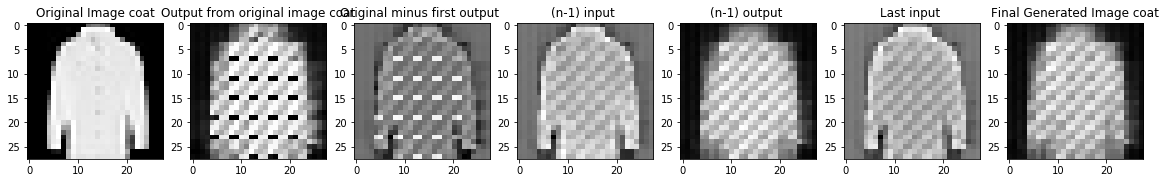

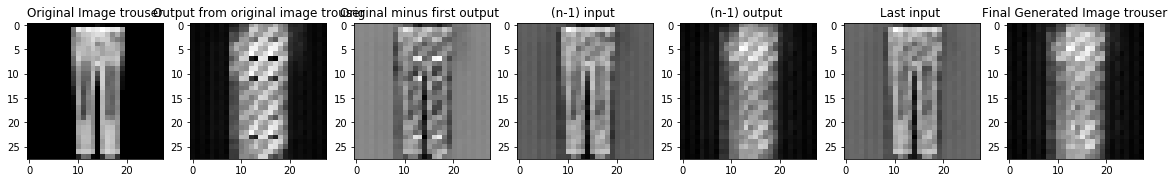

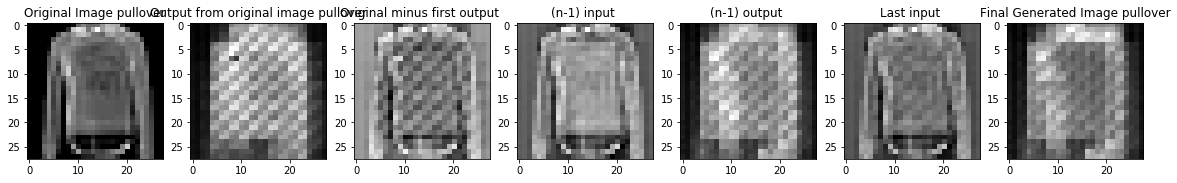

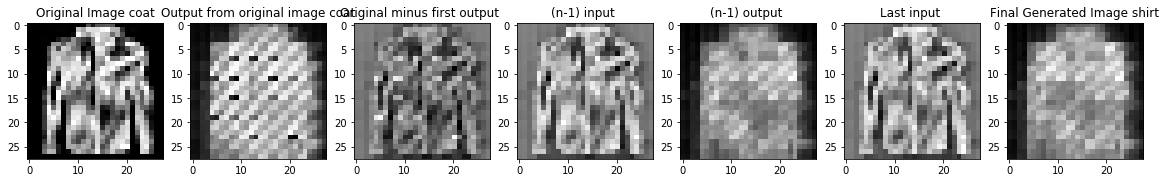

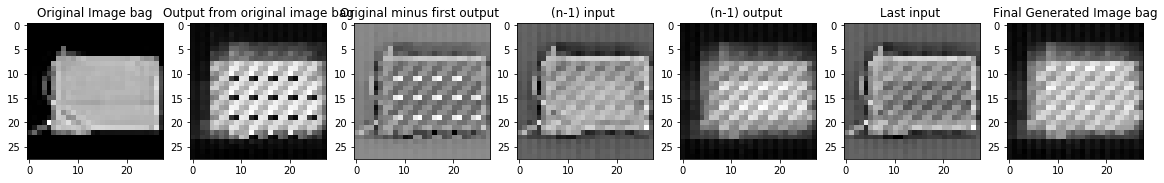

KeyboardInterrupt: ignored

In [0]:
plt.rcParams["figure.figsize"] = (20,3)
inputs = []
outputs = []
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model6(test_images) #first pass
generated_1,predicted_1 = model6(test_images-generated_0) #feedback loop
for i in range(3):
    inputs.append(test_images-generated_1)
    generated_1,predicted_1 = model6(test_images-generated_1)
    outputs.append(generated_1)
_, predicted_label = torch.max(predicted_1, 1)
inp = test_images.view(-1,28,28)
f_inp = (test_images-generated_0).view(-1,28,28)
f_out = generated_0.view(-1,28,28)
inp_1 = inputs[2].view(-1,28,28)
inp_2 = inputs[1].view(-1,28,28)
out_1 = outputs[1].view(-1,28,28)
out = generated_1.view(-1,28,28)
for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 7, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 7, 2)
    plot.set_title('Output from original image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(f_out[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 3)
    plot.set_title('Original minus first output ')
    imgplot = plt.imshow(f_inp[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 4)
    plot.set_title('(n-1) input ')
    imgplot = plt.imshow(inp_2[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 5)
    plot.set_title('(n-1) output ')
    imgplot = plt.imshow(out_1[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 6)
    plot.set_title('Last input ')
    imgplot = plt.imshow(inp_1[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 7)
    plot.set_title('Final Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    
    plt.show()

In [0]:
model6.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model6(images) #first pass
            generated_1,predicted_1 = model6(images-generated_0) #feedback loop
            for i in range(3):
                generated_1,predicted_1 = model6(images-generated_1)
                loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss1+loss2*0.7
            test_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}, test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

Average testing loss: 0.3420, test Accuracy: 9022/10000 (90%)


In [0]:
model9 = Mixed().to(device)
#optimizer = optim.SGD(model6.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model9.parameters(),lr=0.01)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model9.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        generated_0,predicted_0 = model9(images) #first pass
        generated_1,predicted_1 = model9(images-generated_0*0.2) #feedback loop
        alpha = 0.3
        for i in range(3):
          generated_1,predicted_1 = model9(images-generated_1*alpha)
          alpha = alpha + 0.1
          #loss1 = criterion1(generated_1,images)
          loss2 = criterion2(predicted_1,labels)
          loss = loss2
          loss.backward(retain_graph=True)
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model9.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model9(images) #first pass
            generated_1,predicted_1 = model9(images-generated_0*0.2) #feedback loop
            alpha = 0.3
            for i in range(3):
                generated_1,predicted_1 = model9(images-generated_1*alpha)
                alpha = alpha + 0.1
                #loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss2
            val_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 0.8123, Training Accuracy: 34100/48000 (71%)
Average validation loss: 0.5378, Validation Accuracy: 9652/12000 (80%)
Epoch 1
Average training loss: 0.4159, Training Accuracy: 41075/48000 (86%)
Average validation loss: 0.3596, Validation Accuracy: 10404/12000 (87%)
Epoch 2
Average training loss: 0.3553, Training Accuracy: 42086/48000 (88%)
Average validation loss: 0.2978, Validation Accuracy: 10678/12000 (89%)
Epoch 3
Average training loss: 0.3202, Training Accuracy: 42676/48000 (89%)
Average validation loss: 0.3492, Validation Accuracy: 10523/12000 (88%)
Epoch 4
Average training loss: 0.2950, Training Accuracy: 43099/48000 (90%)
Average validation loss: 0.2540, Validation Accuracy: 10892/12000 (91%)
Epoch 5
Average training loss: 0.2731, Training Accuracy: 43425/48000 (90%)
Average validation loss: 0.2622, Validation Accuracy: 10949/12000 (91%)
Epoch 6
Average training loss: 0.2682, Training Accuracy: 43611/48000 (91%)
Average validation loss: 0.2713, Vali

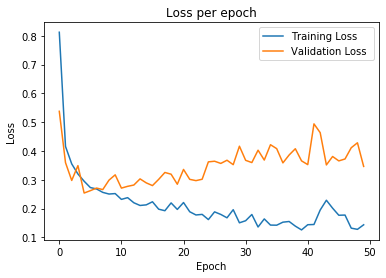

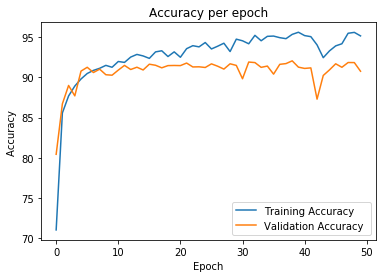

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")

In [0]:
plt.rcParams["figure.figsize"] = (20,3)
inputs = []
outputs = []
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model9(test_images) #first pass
generated_1,predicted_1 = model9(test_images-generated_0*0.2) #feedback loop
alpha = 0.3
for i in range(3):
    inputs.append(test_images-generated_1)
    generated_1,predicted_1 = model9(test_images-generated_1*alpha)
    alpha = alpha + 0.1
    outputs.append(generated_1)
_, predicted_label = torch.max(predicted_1, 1)
inp = test_images.view(-1,28,28)
f_inp = (test_images-generated_0).view(-1,28,28)
f_out = generated_0.view(-1,28,28)
inp_1 = inputs[2].view(-1,28,28)
inp_2 = inputs[1].view(-1,28,28)
out_1 = outputs[1].view(-1,28,28)
out = generated_1.view(-1,28,28)
for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 8, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 8, 2)
    plot.set_title('Output from original image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(f_out[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 8, 3)
    plot.set_title('Original minus first output ' + str(classes[labels[i]]))
    imgplot = plt.imshow(f_inp[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 8, 4)
    plot.set_title('(n-1) input ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp_2[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 8, 5)
    plot.set_title('(n-1) output ' + str(classes[labels[i]]))
    imgplot = plt.imshow(out_1[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 8, 6)
    plot.set_title('Last input ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp_1[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 8, 7)
    plot.set_title('Final Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 8, 8)
    plot.set_title('Diff last two outs ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu.detach()-out_1[i].cpu().detach(), cmap='gray')
    
    plt.show()

NameError: ignored

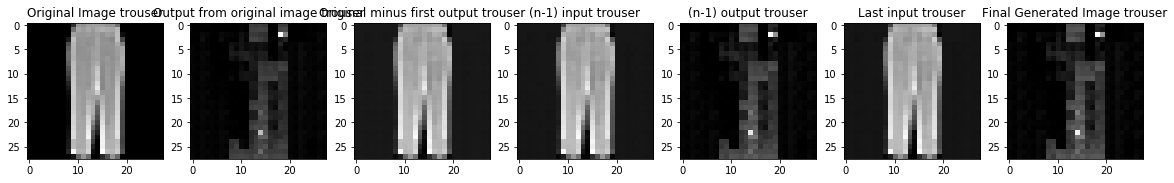

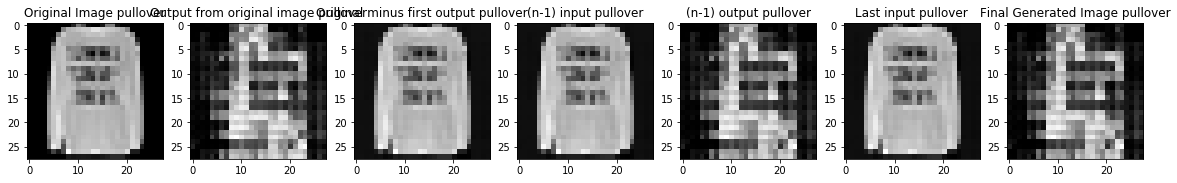

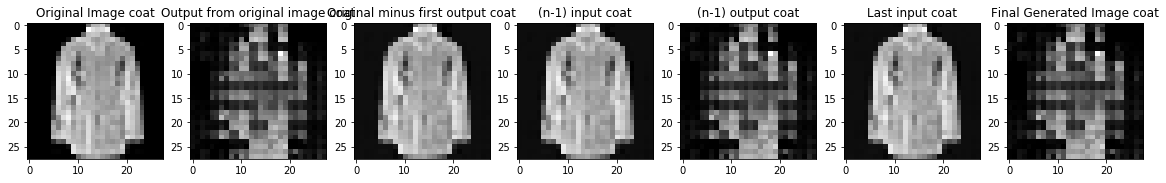

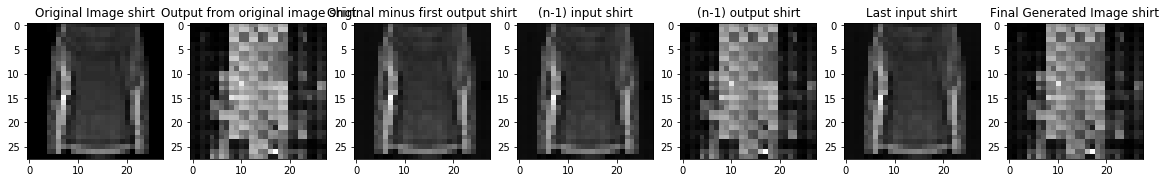

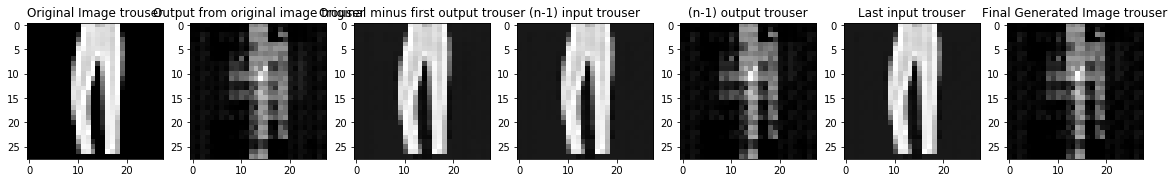

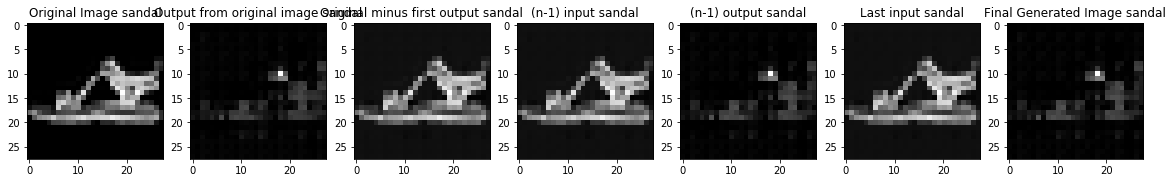

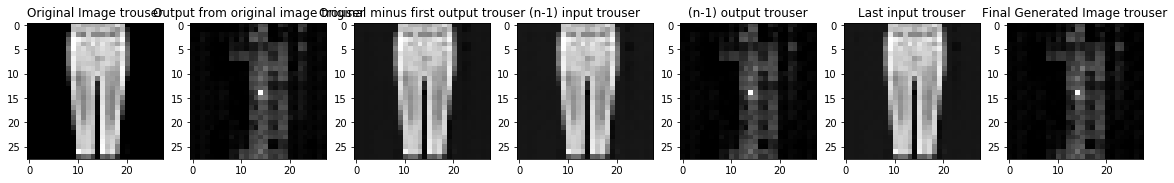

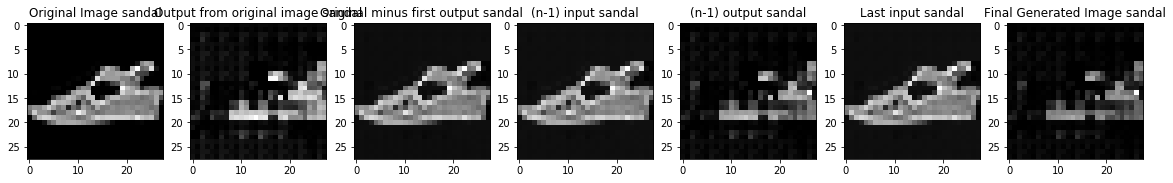

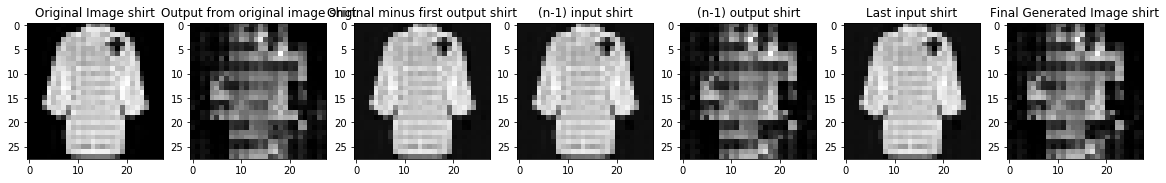

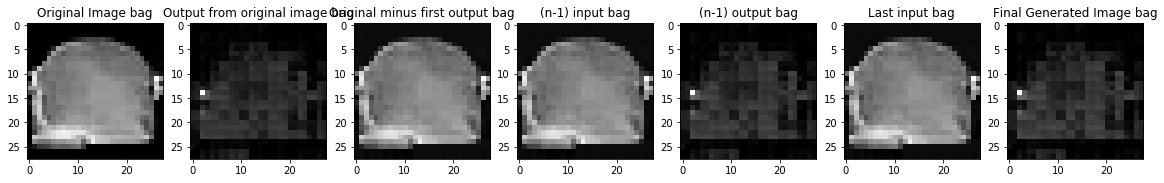

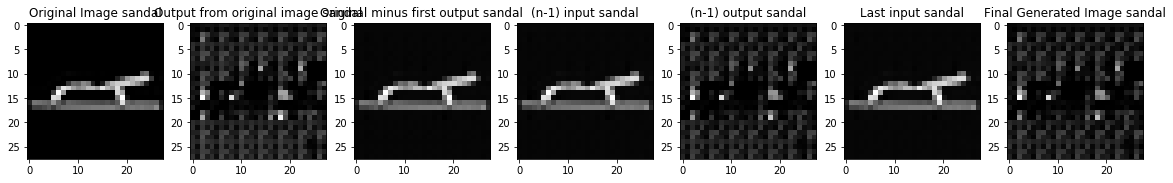

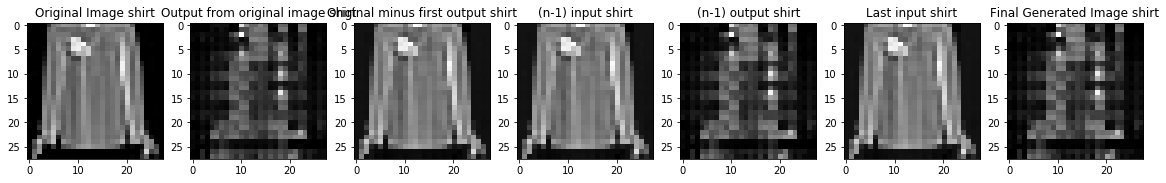

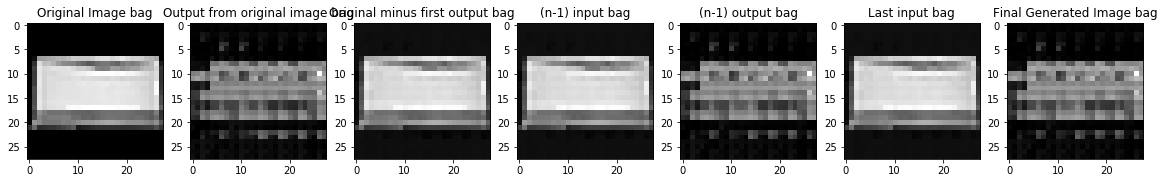

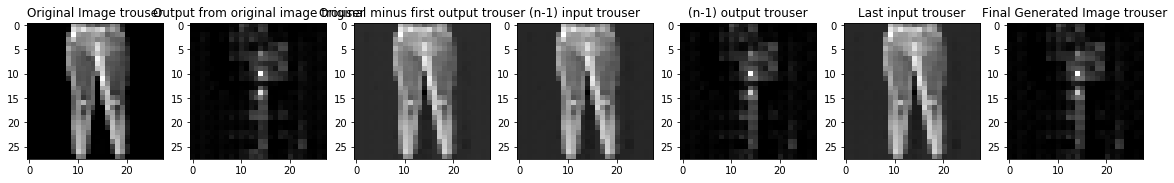

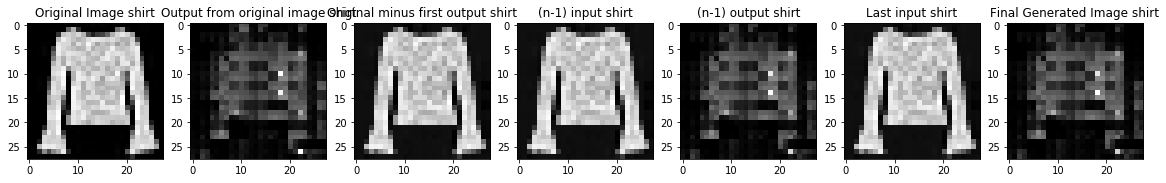

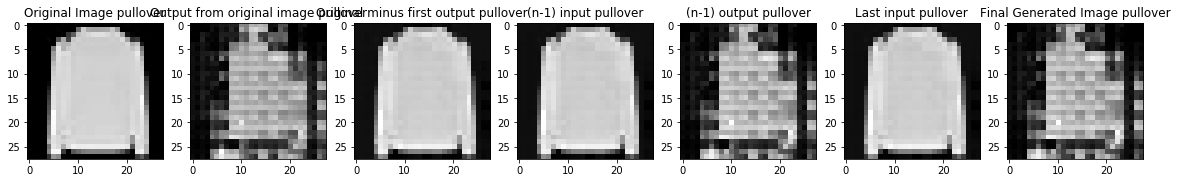

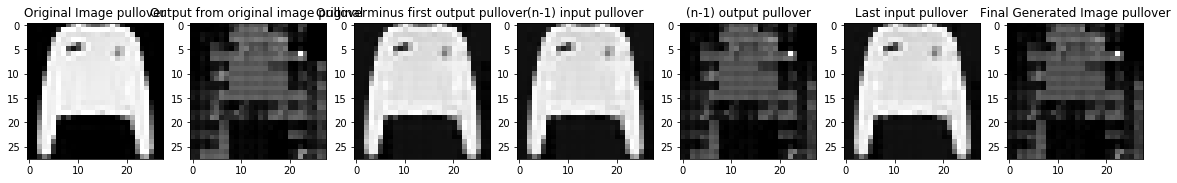

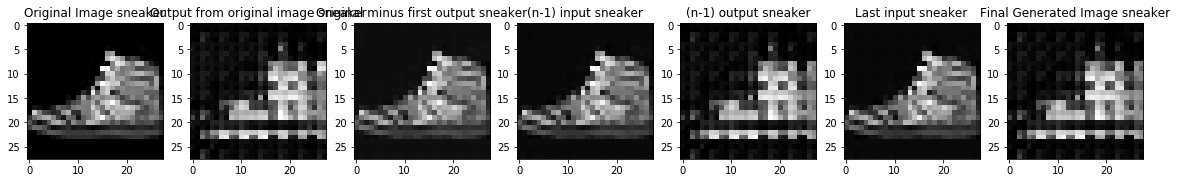

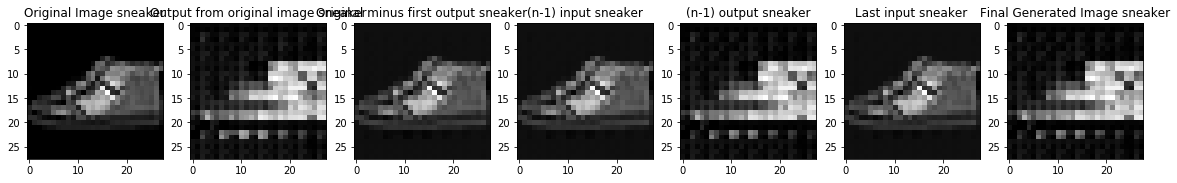

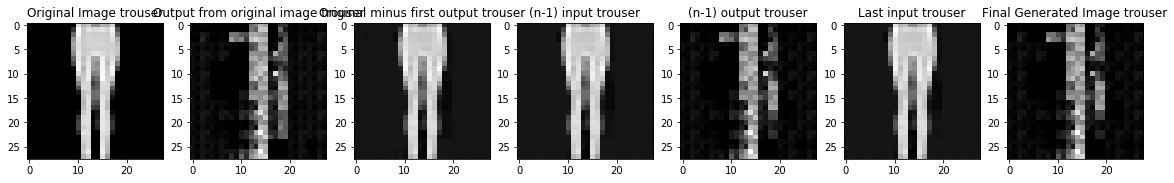

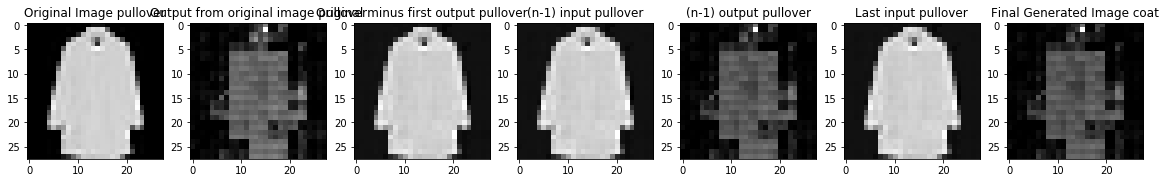

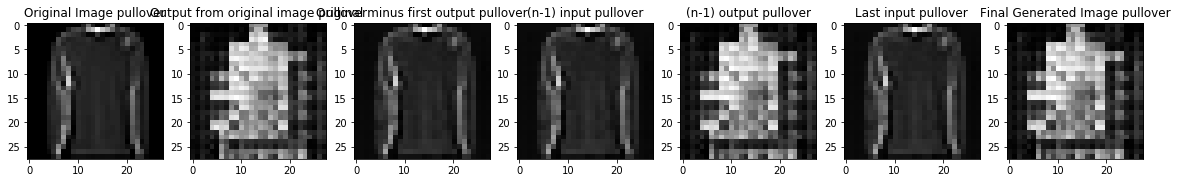

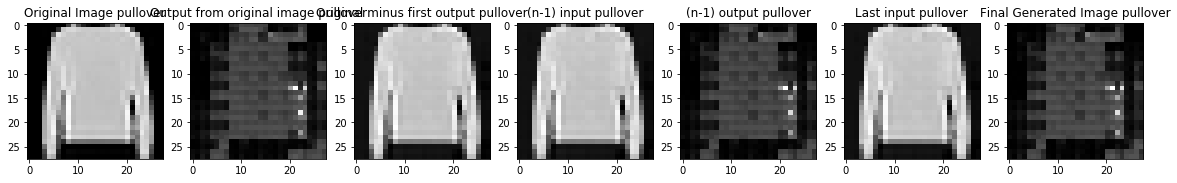

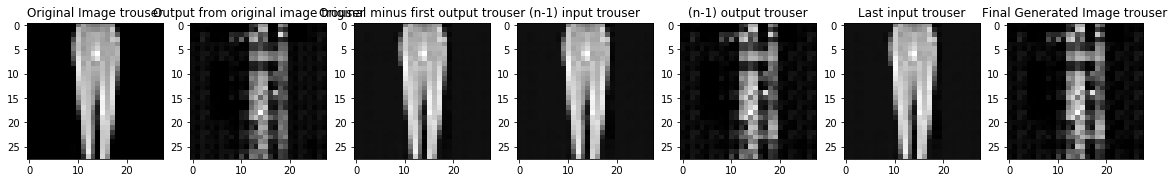

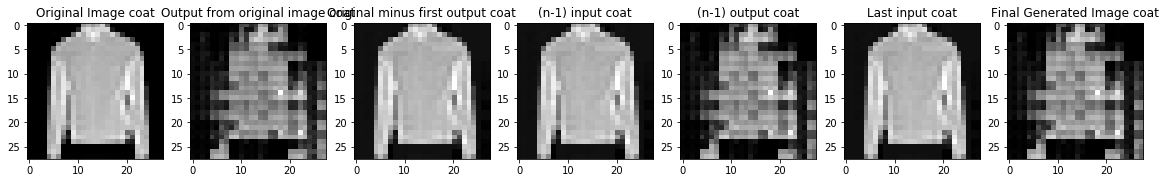

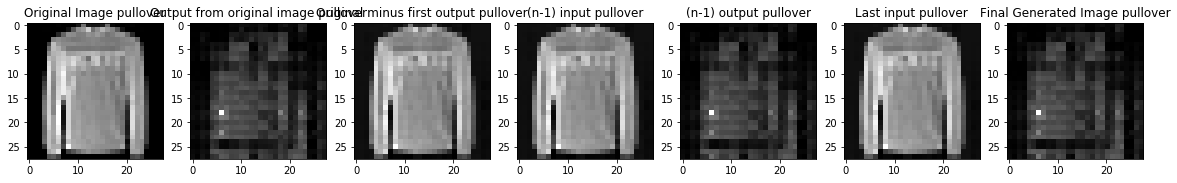

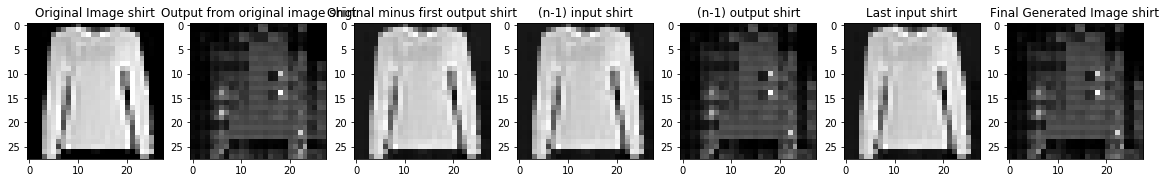

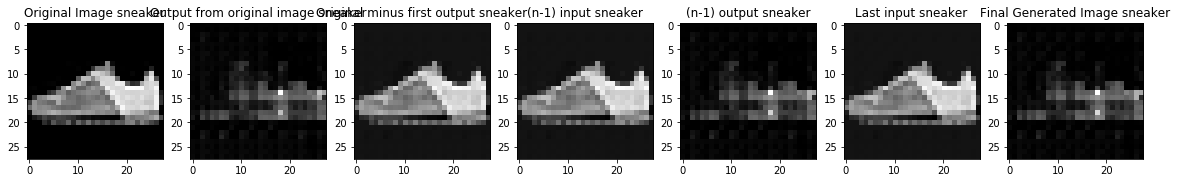

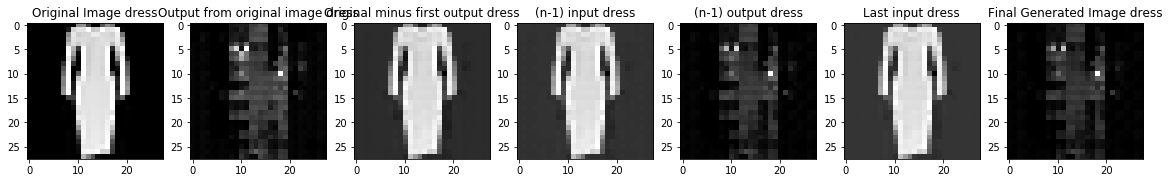

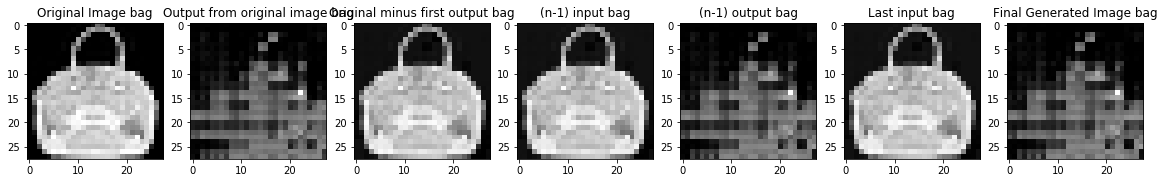

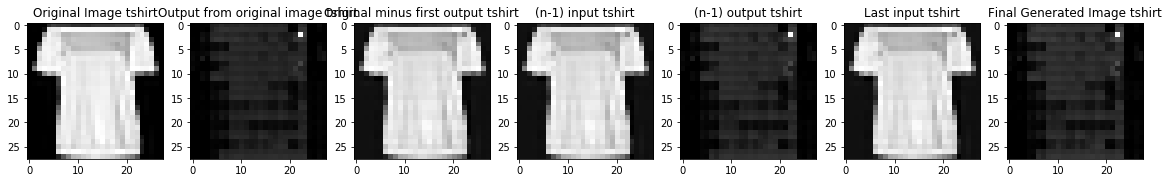

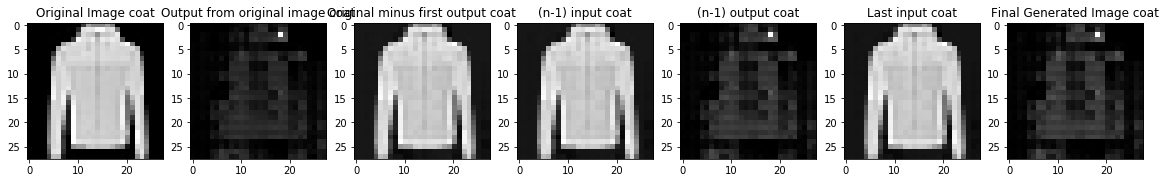

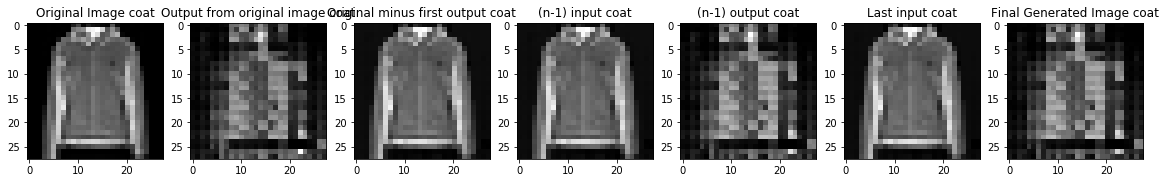

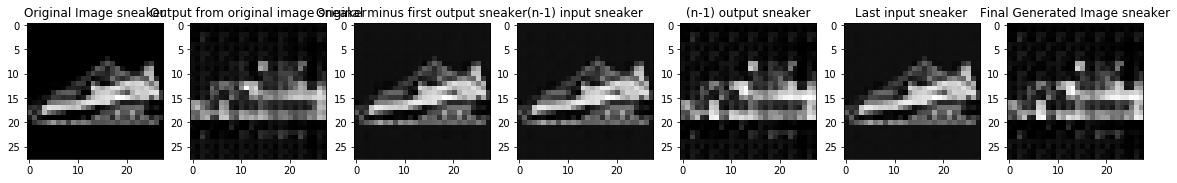

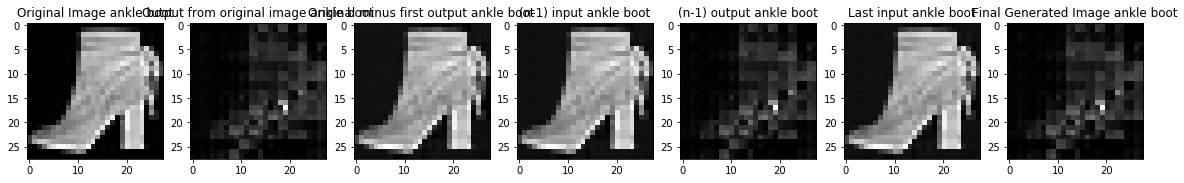

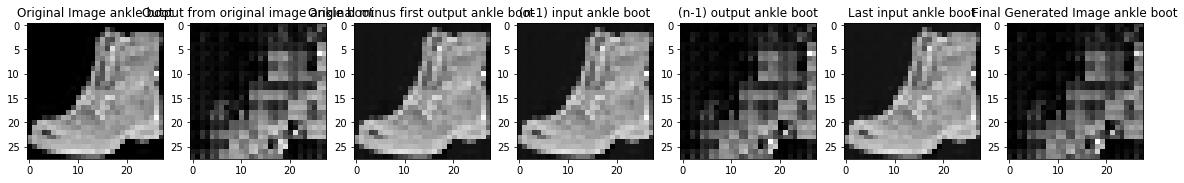

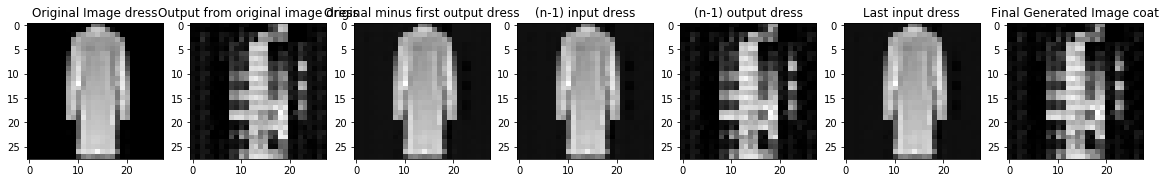

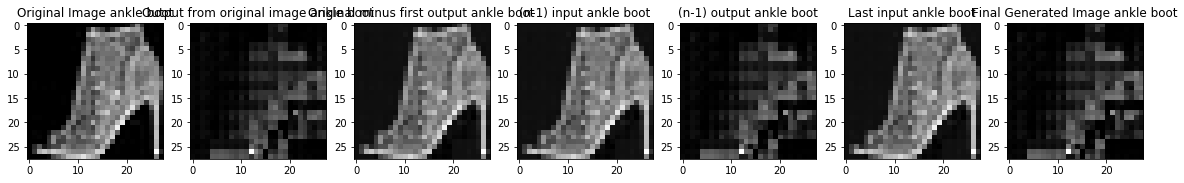

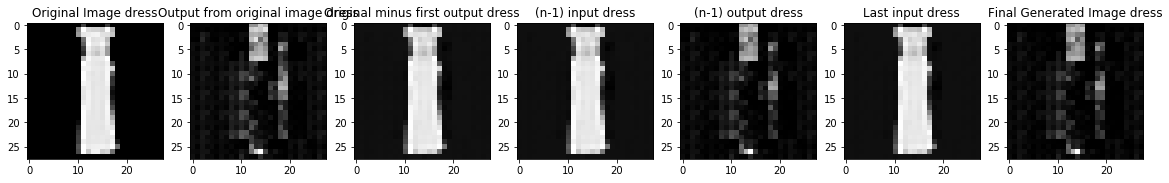

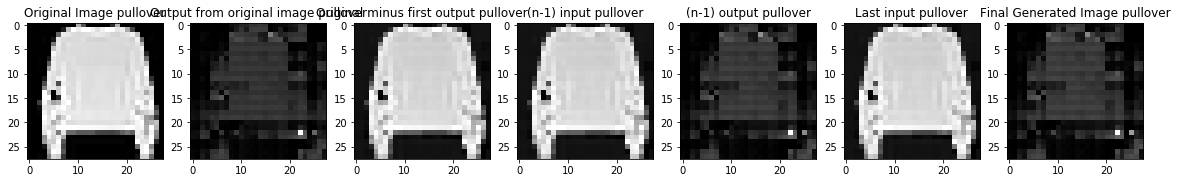

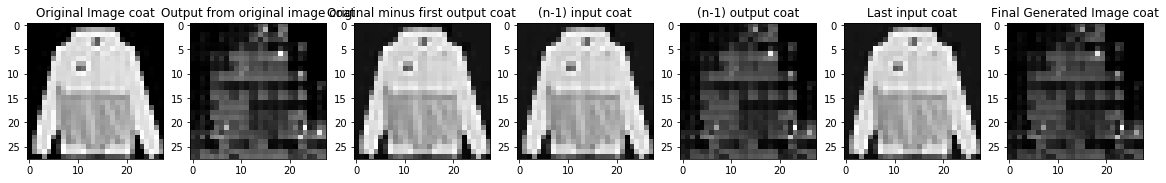

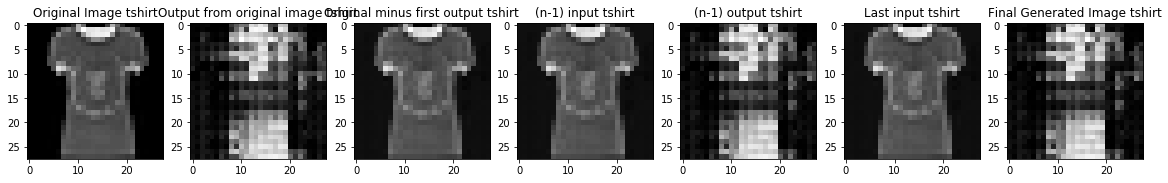

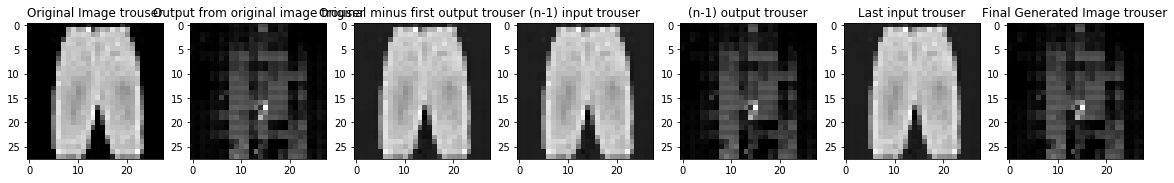

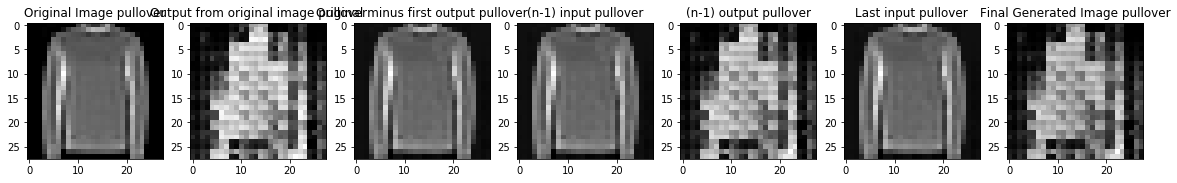

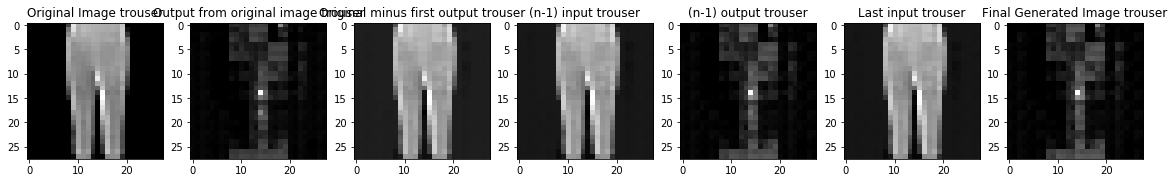

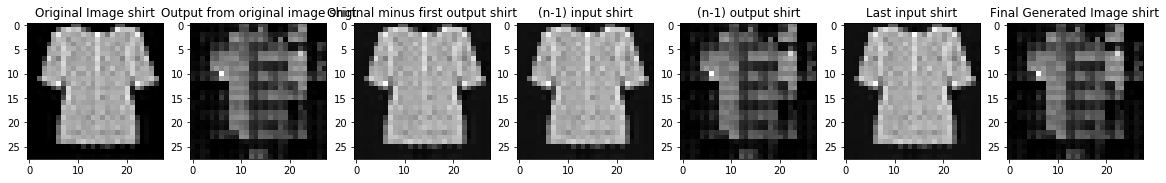

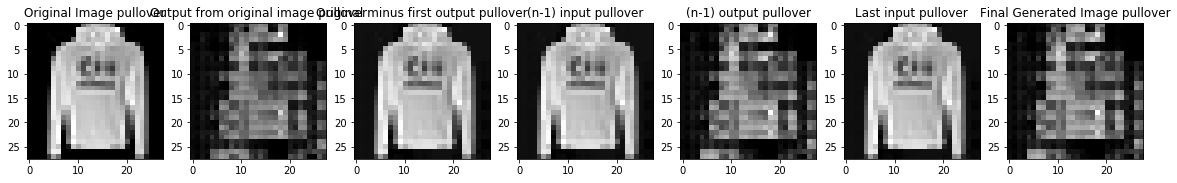

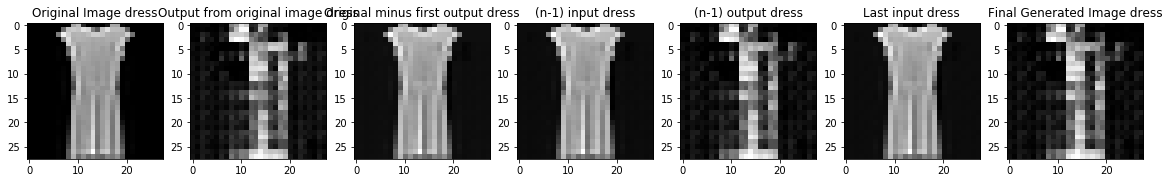

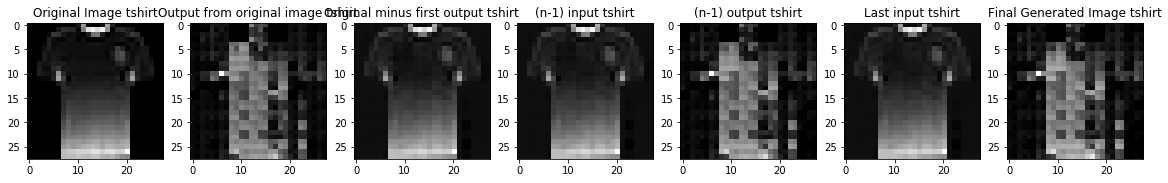

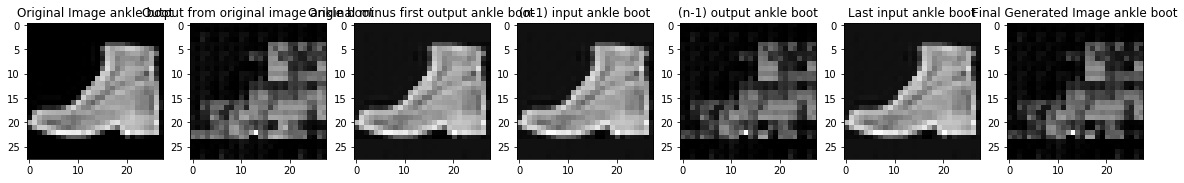

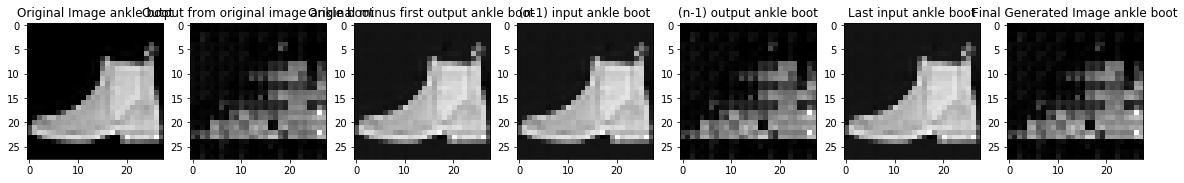

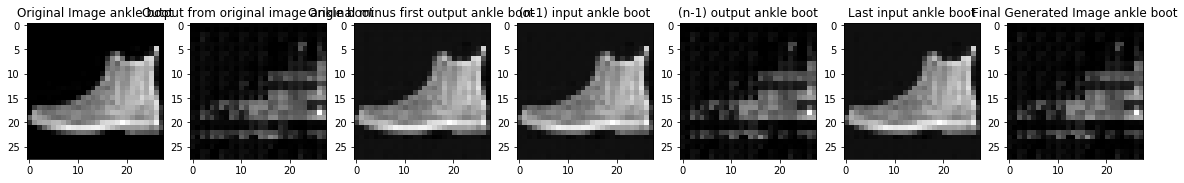

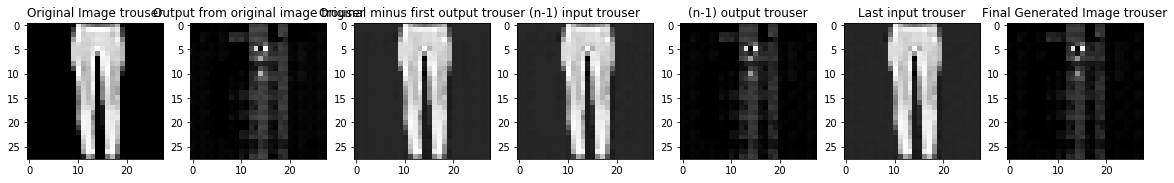

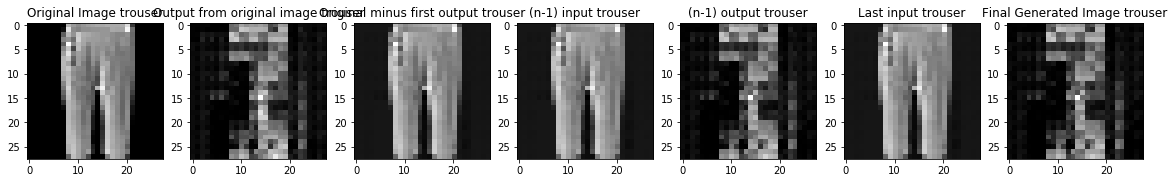

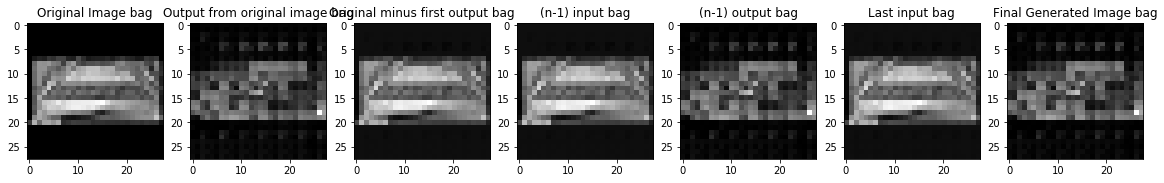

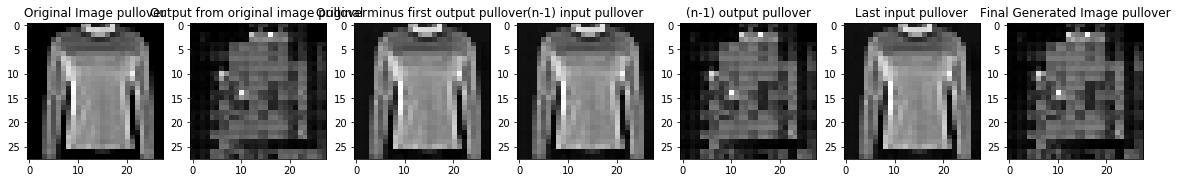

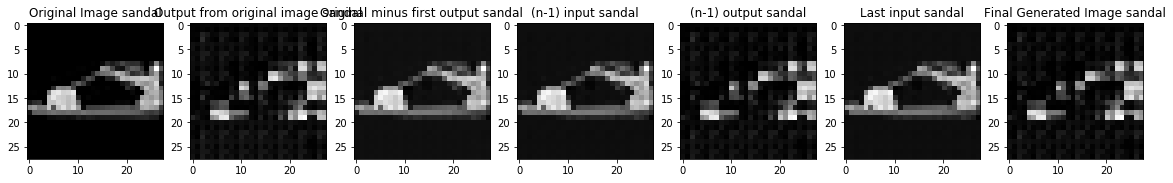

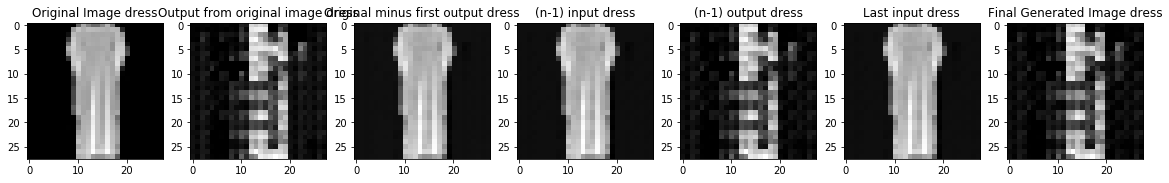

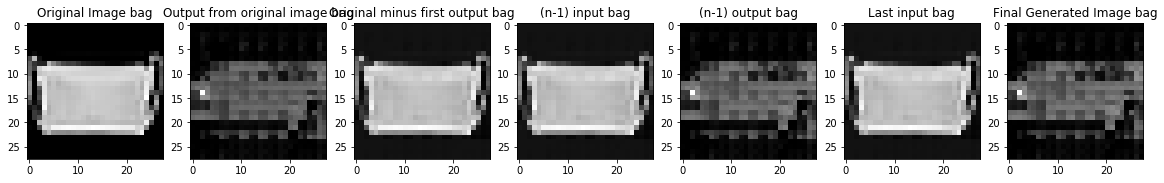

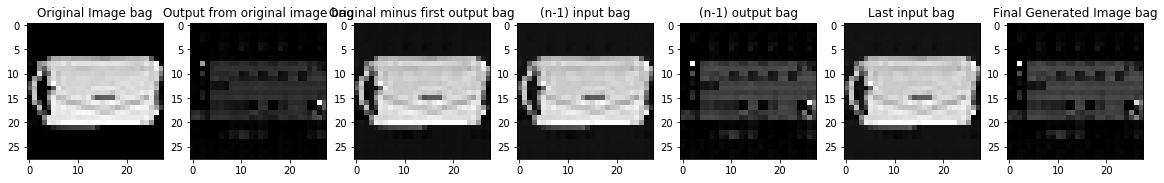

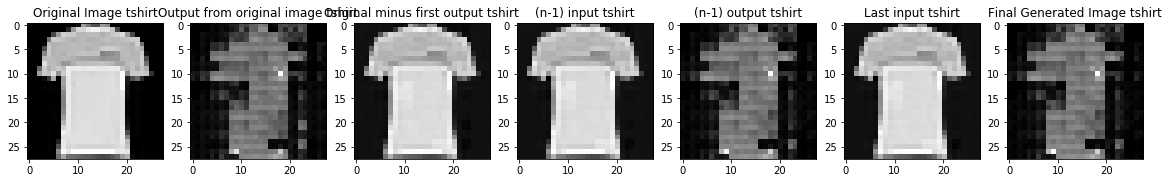

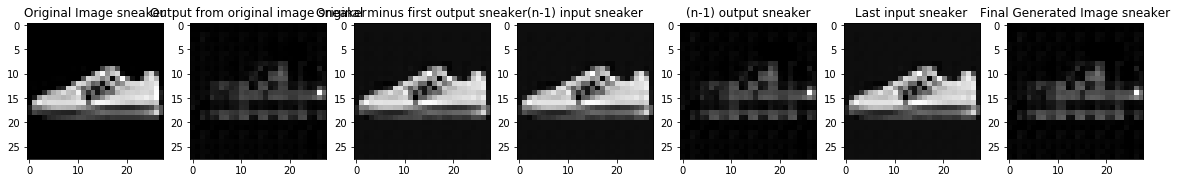

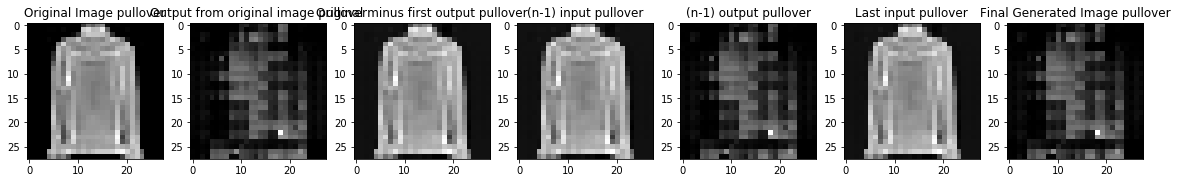

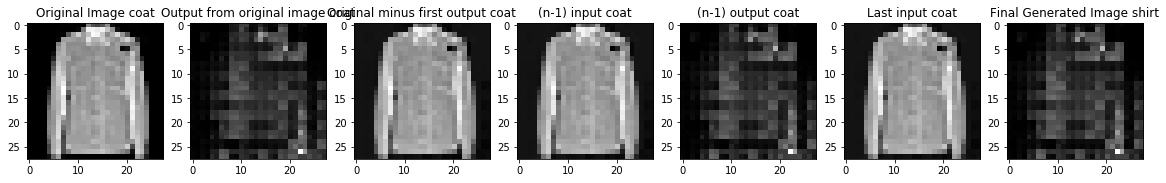

In [0]:
plt.rcParams["figure.figsize"] = (20,3)
inputs = []
outputs = []
test_images, labels = next(iter(trainloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model9(test_images) #first pass
generated_1,predicted_1 = model9(test_images-generated_0*0.2) #feedback loop
alpha = 0.3
for i in range(3):
    inputs.append(test_images-generated_1)
    generated_1,predicted_1 = model9(test_images-generated_1*alpha)
    alpha = alpha + 0.1
    outputs.append(generated_1)
_, predicted_label = torch.max(predicted_1, 1)
inp = test_images.view(-1,28,28)
f_inp = (test_images-generated_0).view(-1,28,28)
f_out = generated_0.view(-1,28,28)
inp_1 = inputs[2].view(-1,28,28)
inp_2 = inputs[1].view(-1,28,28)
out_1 = outputs[1].view(-1,28,28)
out = generated_1.view(-1,28,28)
for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 7, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 7, 2)
    plot.set_title('Output from original image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(f_out[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 3)
    plot.set_title('Original minus first output ' + str(classes[labels[i]]))
    imgplot = plt.imshow(f_inp[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 4)
    plot.set_title('(n-1) input ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp_2[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 5)
    plot.set_title('(n-1) output ' + str(classes[labels[i]]))
    imgplot = plt.imshow(out_1[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 6)
    plot.set_title('Last input ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp_1[i].cpu().detach(), cmap='gray')
    plot = fig.add_subplot(1, 7, 7)
    plot.set_title('Final Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    
    plt.show()

In [0]:
model9.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model9(images) #first pass
            generated_1,predicted_1 = model9(images-generated_0*0.2) #feedback loop
            alpha = 0.3
            for i in range(3):
                generated_1,predicted_1 = model9(images-generated_1*alpha)
                alpha = alpha + 0.1
                loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss1
            test_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}, test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

Average testing loss: 0.2766, test Accuracy: 9118/10000 (91%)


In [0]:
model8 = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model8.parameters(),lr=0.01)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model8.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        generated_0,predicted_0 = model8(images) #first pass
        generated_1,predicted_1 = model8(images-generated_0) #feedback loop
        for i in range(3):
          generated_1,predicted_1 = model8(images-generated_1)
          loss1 = (criterion1(generated_1,images)-train_mean_auto)/train_std_auto
          loss2 = (criterion2(predicted_1,labels)-train_class_mean)/train_class_std
          loss = loss1+loss2
          loss.backward(retain_graph=True)
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model8.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model8(images) #first pass
            generated_1,predicted_1 = model8(images-generated_0) #feedback loop
            for i in range(3):
                generated_1,predicted_1 = model8(images-generated_1)
                loss1 = (criterion1(generated_1,images)-val_mean_auto)/val_std_auto
                loss2 = (criterion2(predicted_1,labels)-val_class_mean)/val_class_std
                loss = loss1+loss2
            val_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 20.2153, Training Accuracy: 32700/48000 (68%)
Average validation loss: 55.2044, Validation Accuracy: 9560/12000 (80%)
Epoch 1
Average training loss: 9.8856, Training Accuracy: 38942/48000 (81%)
Average validation loss: 36.9259, Validation Accuracy: 10118/12000 (84%)
Epoch 2
Average training loss: 7.9986, Training Accuracy: 40340/48000 (84%)
Average validation loss: 66.0690, Validation Accuracy: 9799/12000 (82%)
Epoch 3
Average training loss: 6.8110, Training Accuracy: 40844/48000 (85%)
Average validation loss: 59.1430, Validation Accuracy: 10235/12000 (85%)
Epoch 4
Average training loss: 5.7606, Training Accuracy: 41167/48000 (86%)
Average validation loss: 54.2074, Validation Accuracy: 9958/12000 (83%)
Epoch 5
Average training loss: 5.0534, Training Accuracy: 41430/48000 (86%)
Average validation loss: 74.5421, Validation Accuracy: 9436/12000 (79%)
Epoch 6
Average training loss: 4.6111, Training Accuracy: 41622/48000 (87%)
Average validation loss: 83.9744,

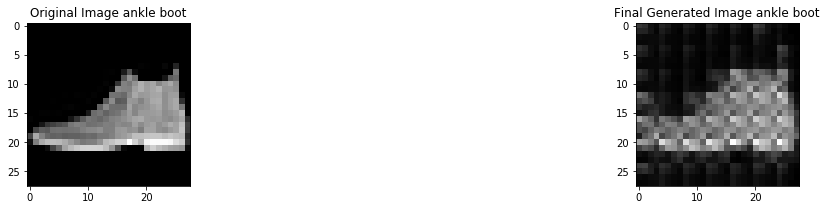

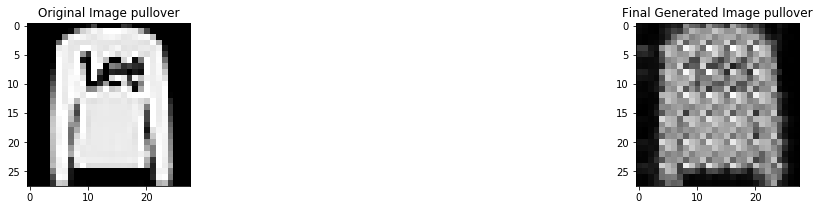

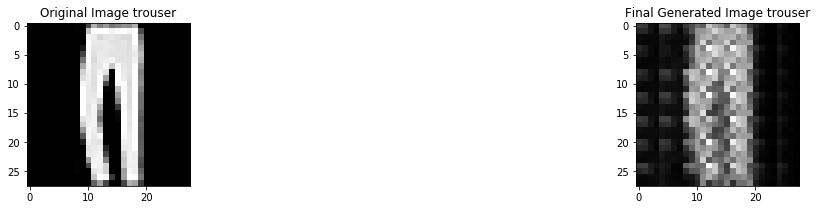

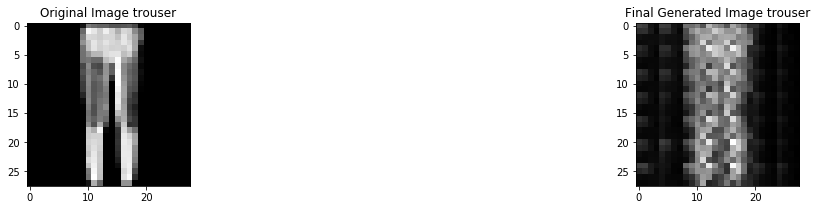

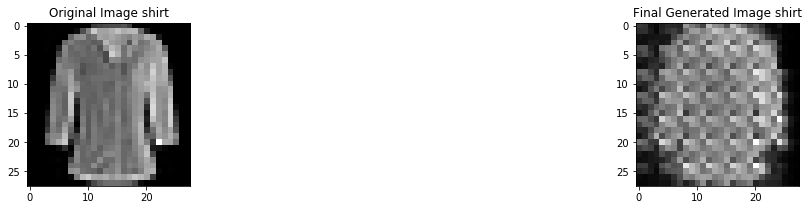

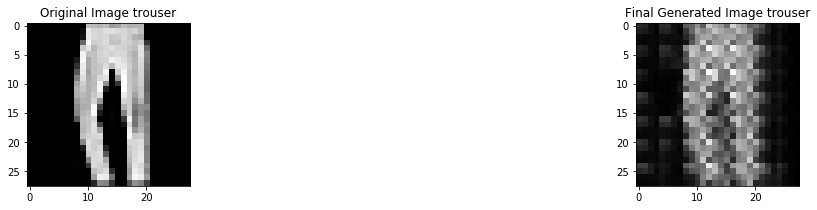

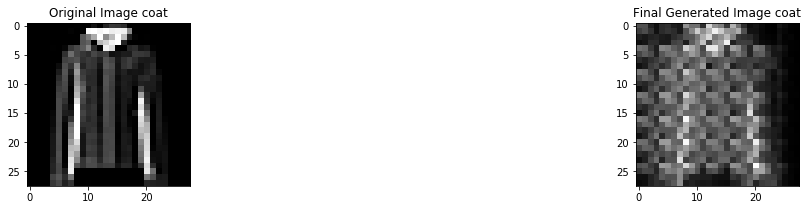

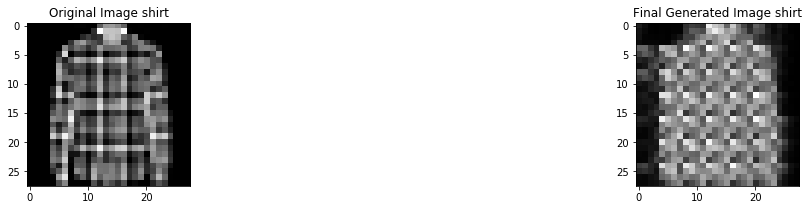

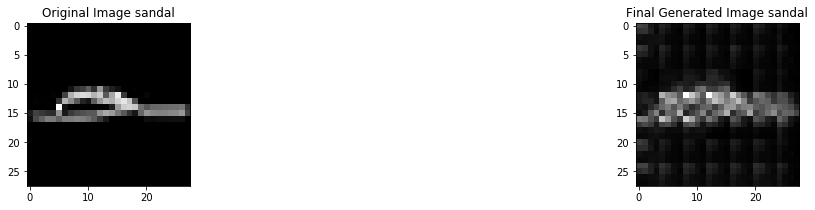

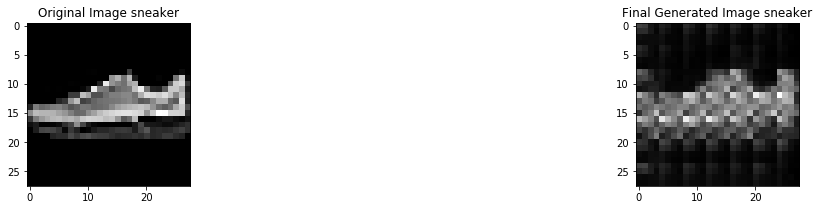

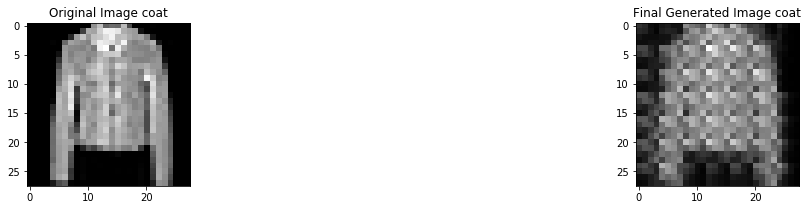

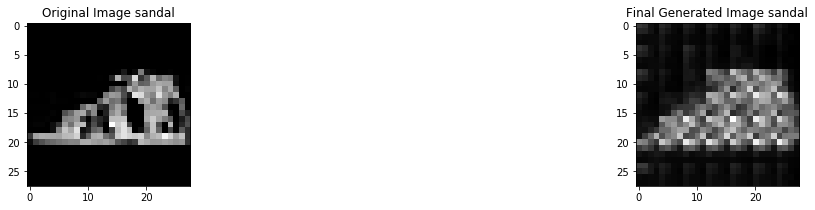

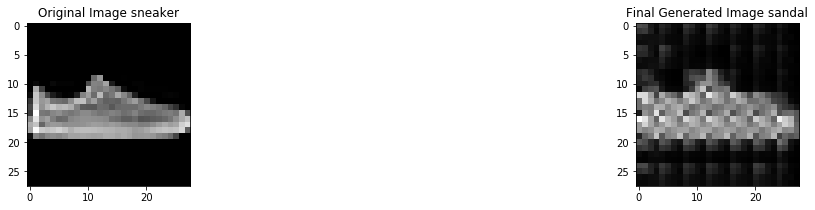

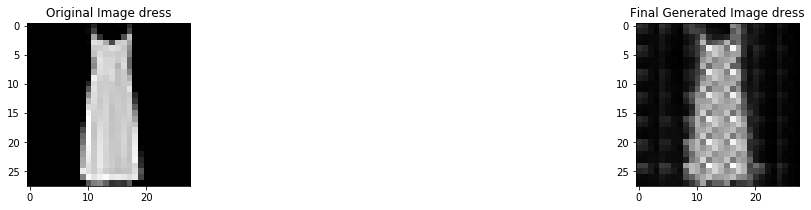

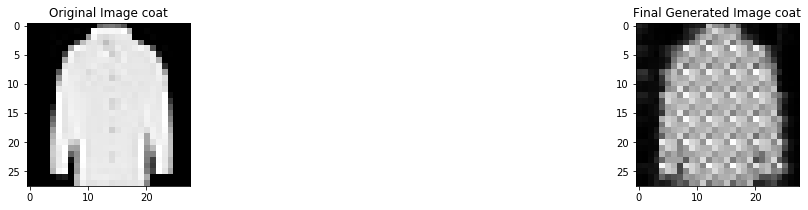

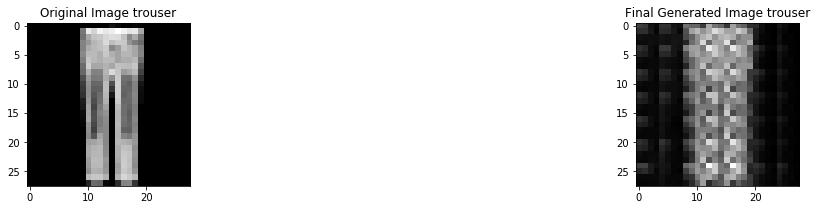

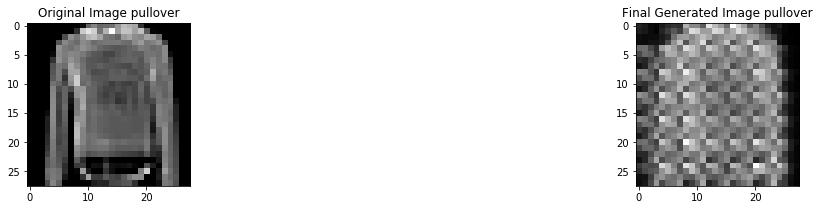

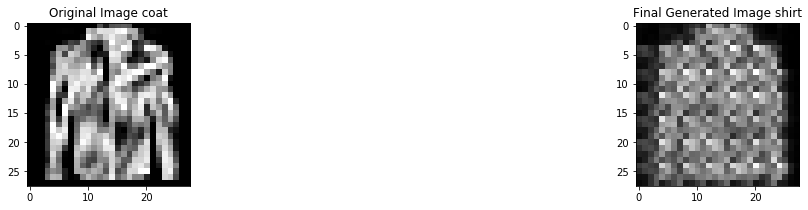

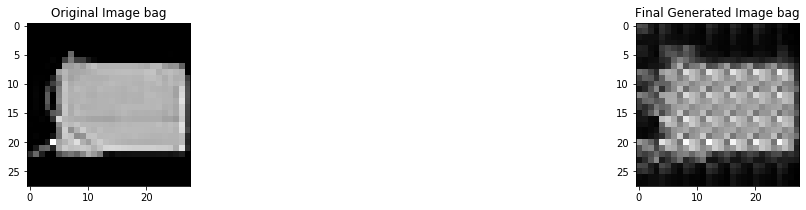

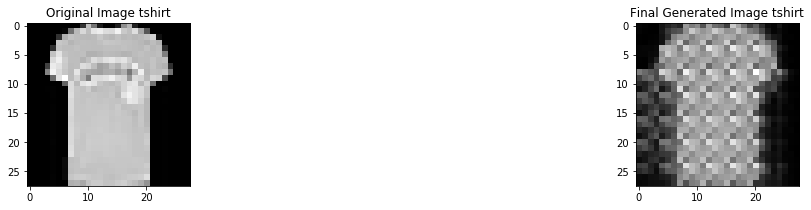

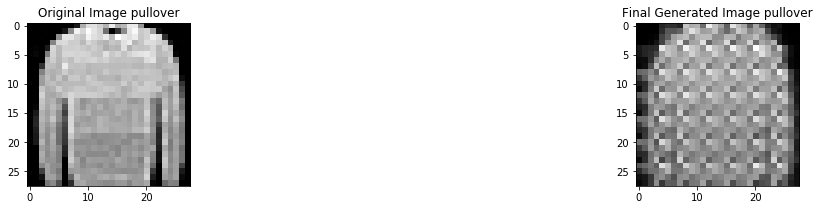

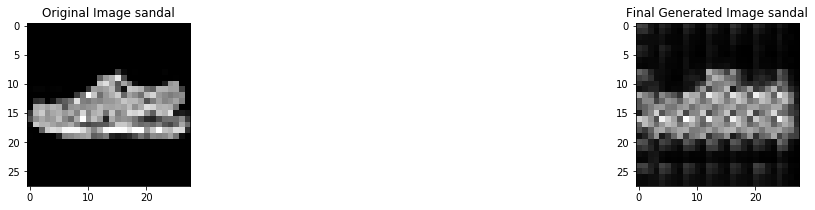

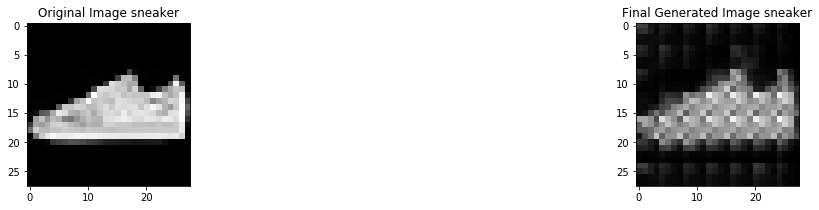

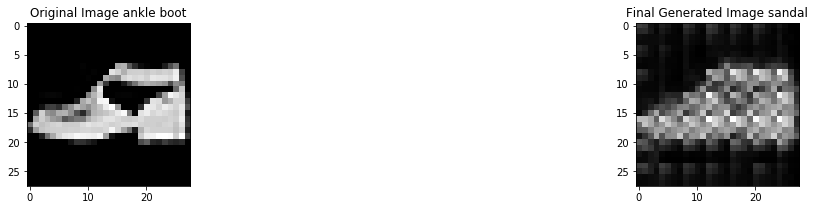

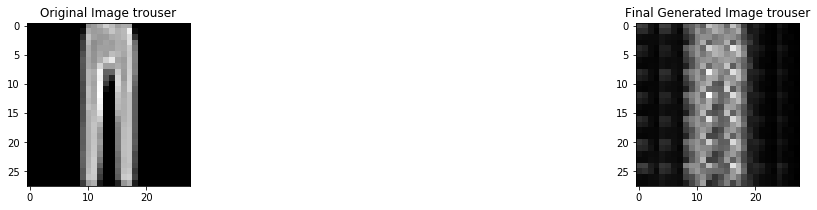

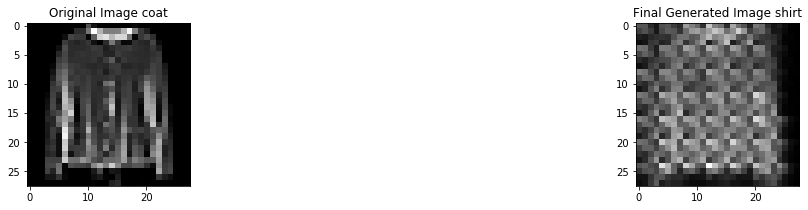

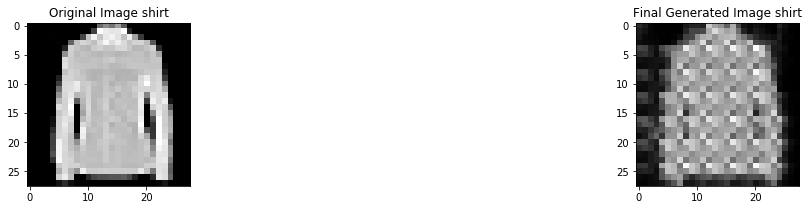

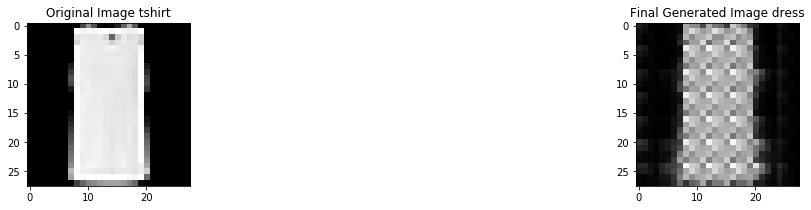

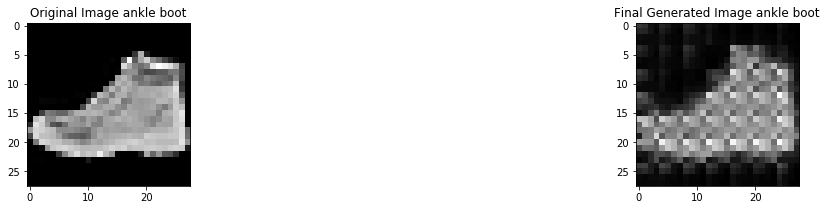

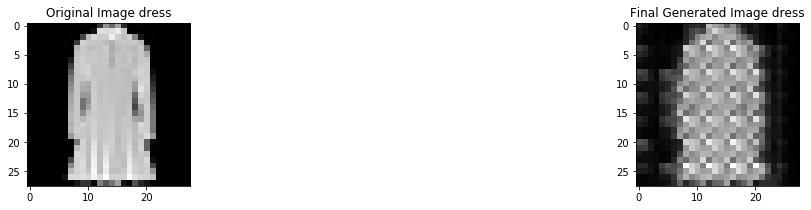

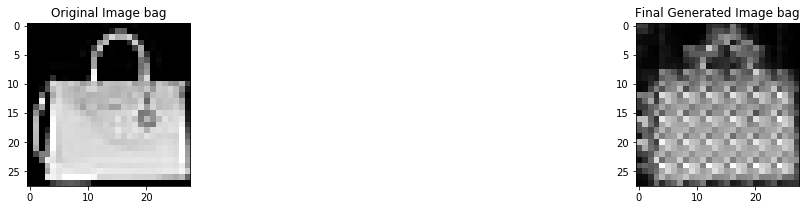

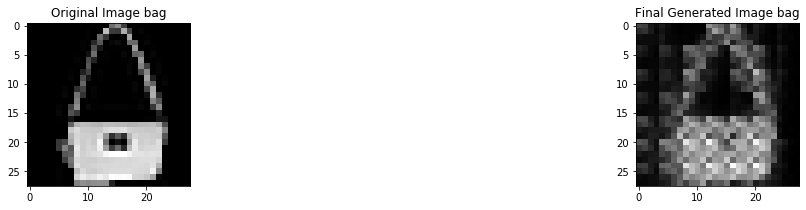

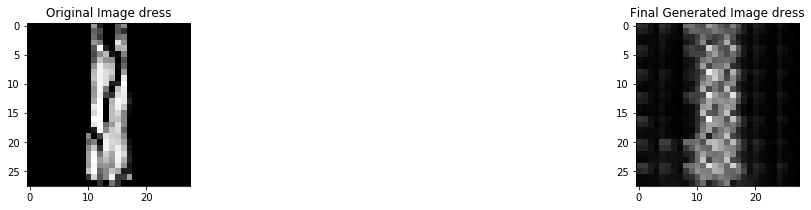

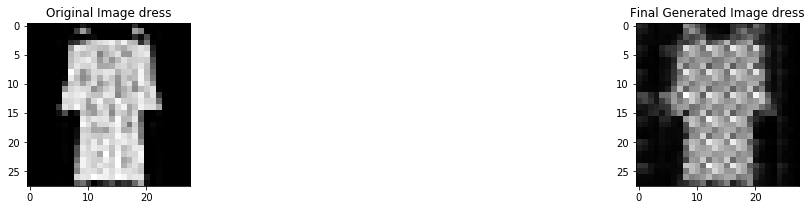

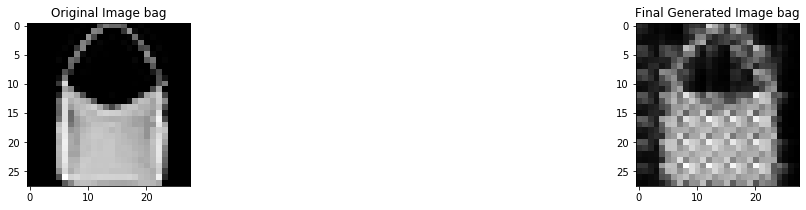

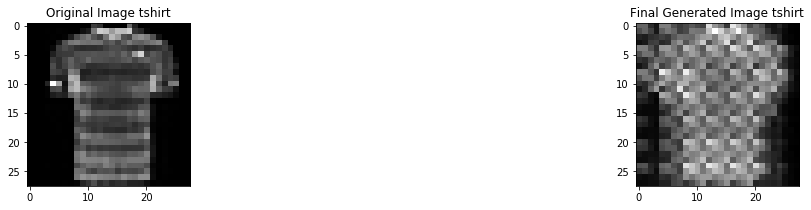

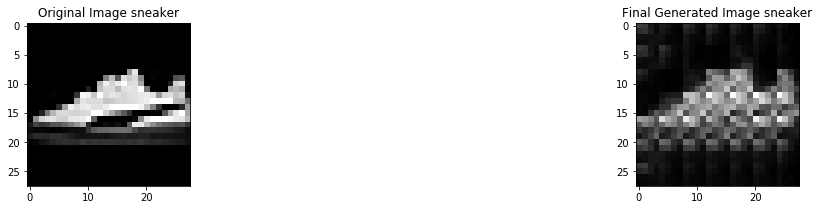

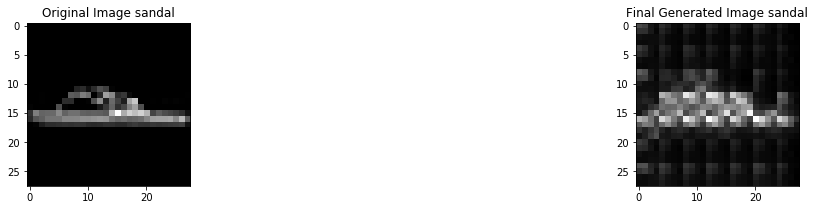

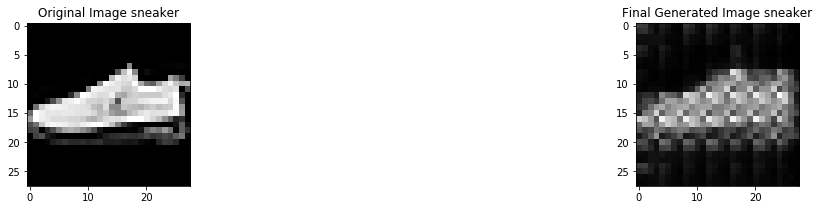

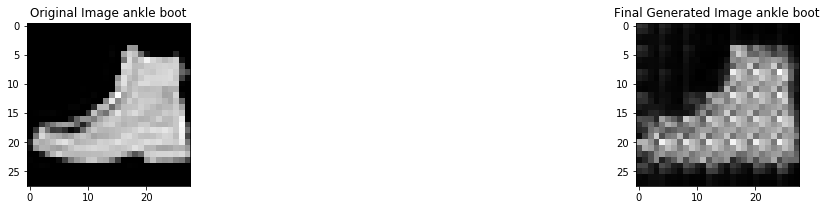

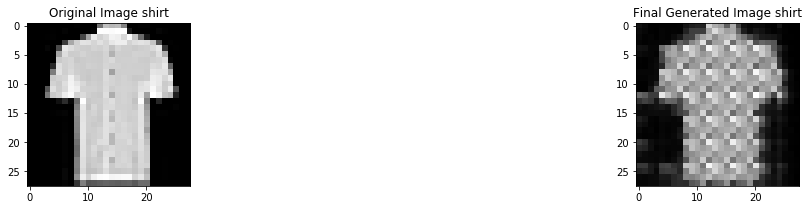

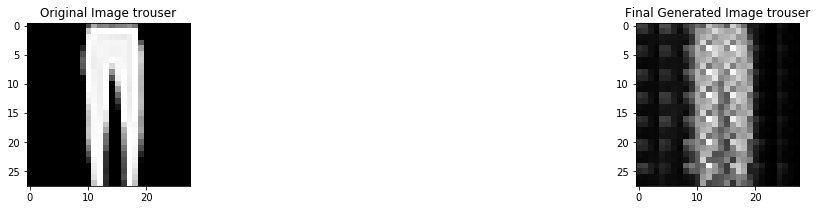

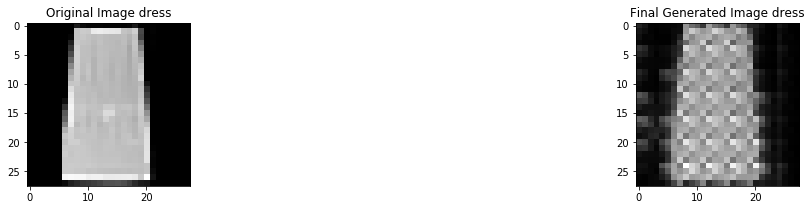

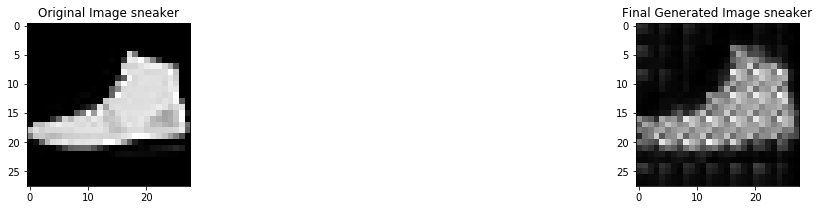

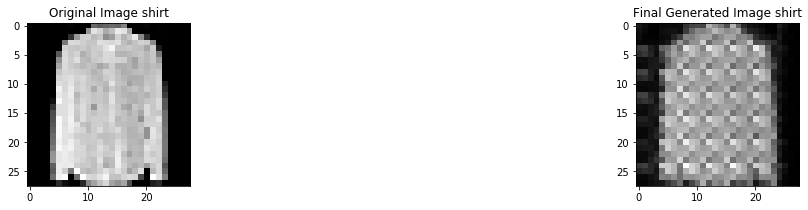

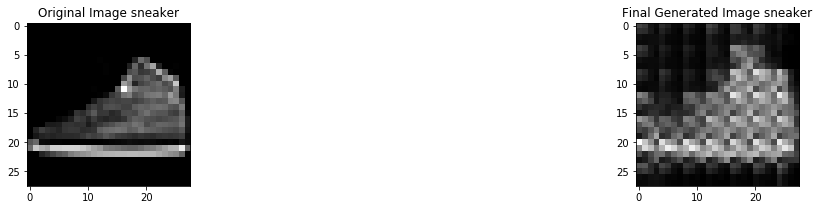

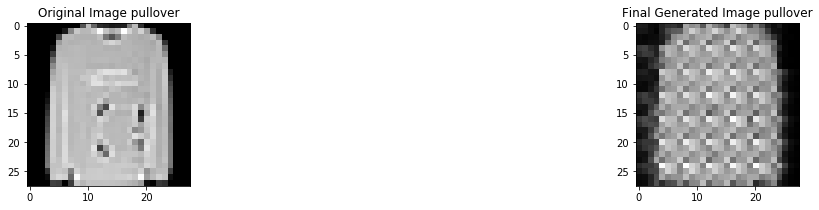

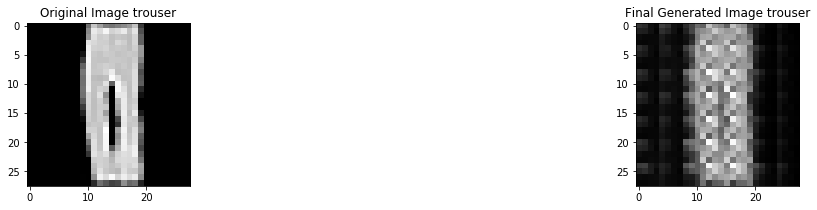

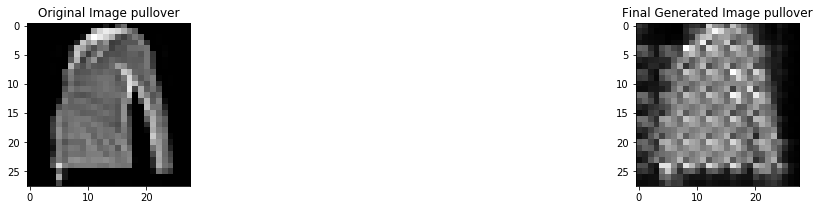

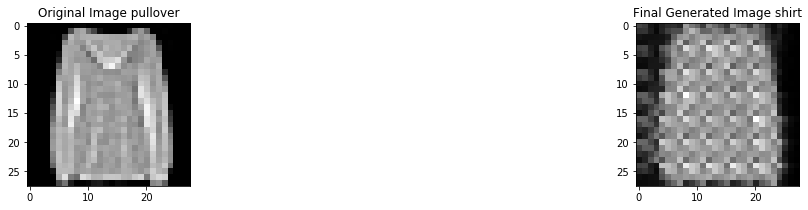

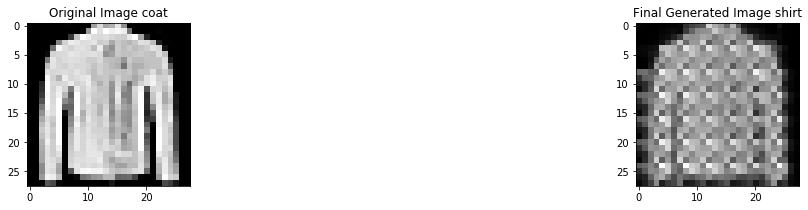

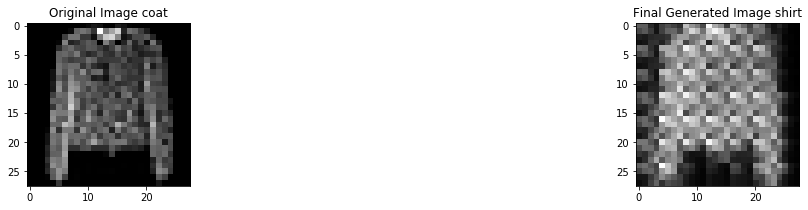

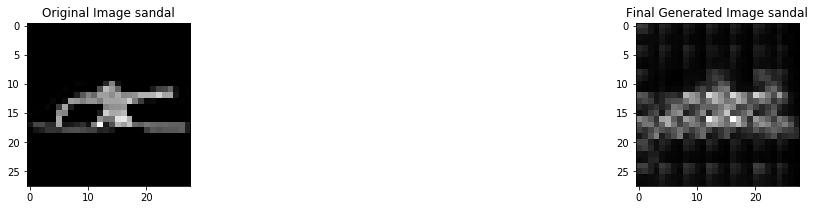

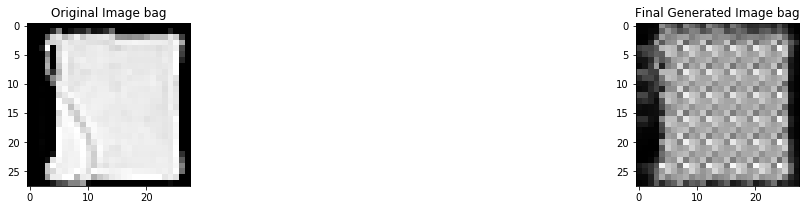

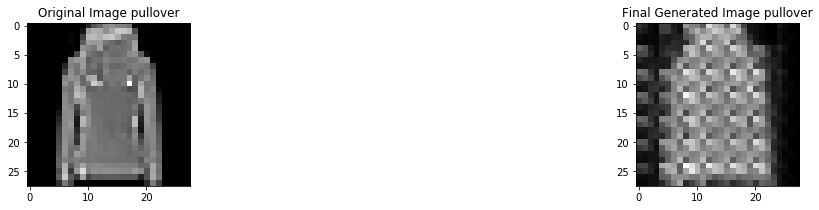

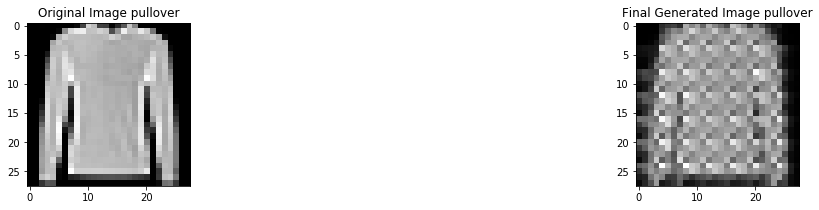

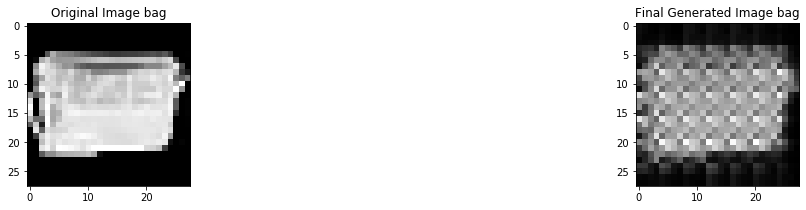

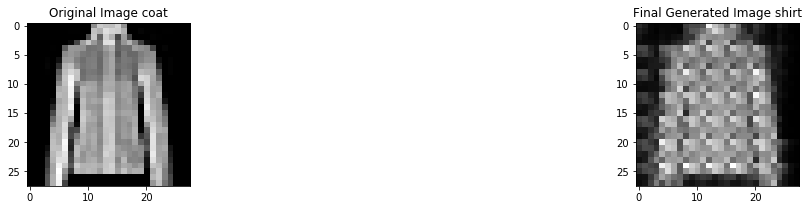

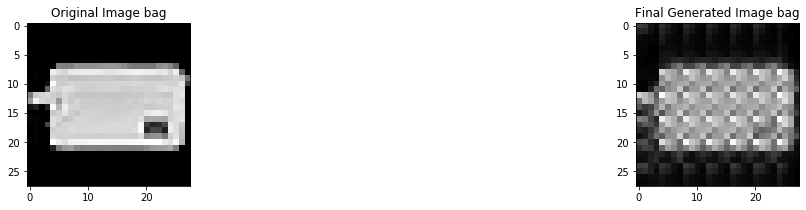

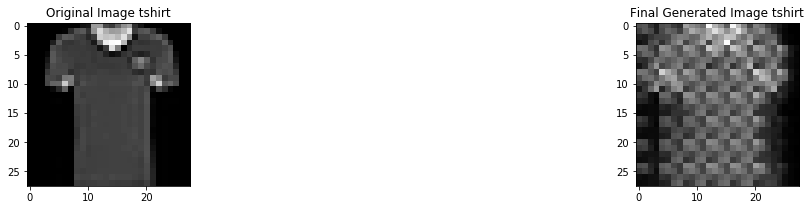

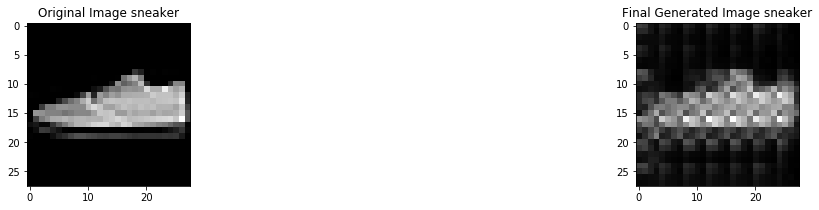

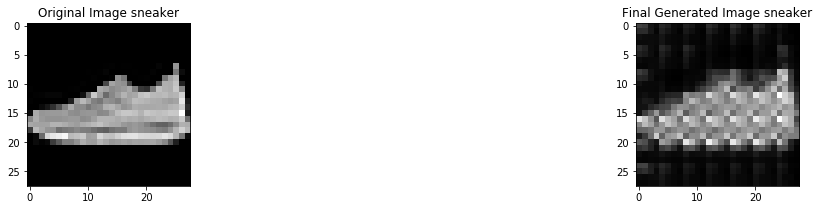

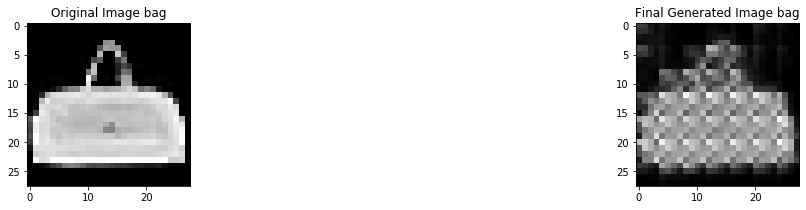

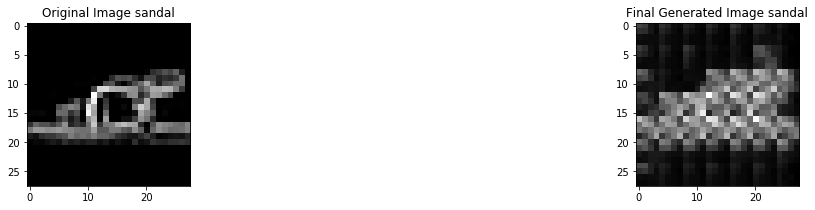

In [0]:
plt.rcParams["figure.figsize"] = (20,3)
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model8(test_images) #first pass
generated_1,predicted_1 = model8(test_images-generated_0) #feedback loop
for i in range(3):
    generated_1,predicted_1 = model8(test_images-generated_1)
_, predicted_label = torch.max(predicted_1, 1)
inp = test_images.view(-1,28,28)
out = generated_1.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Final Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    
    plt.show()

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")

Average testing loss: 0.3292, test Accuracy: 8568/10000 (86%)


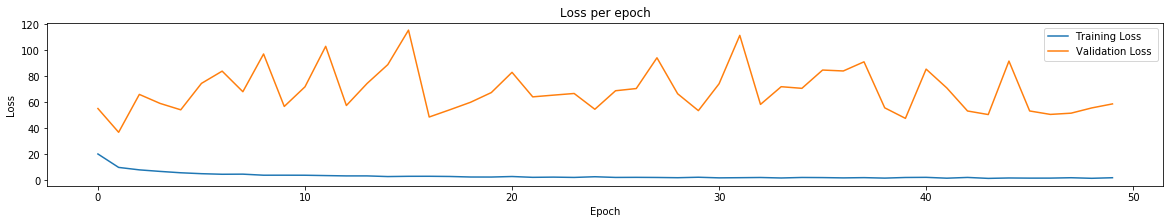

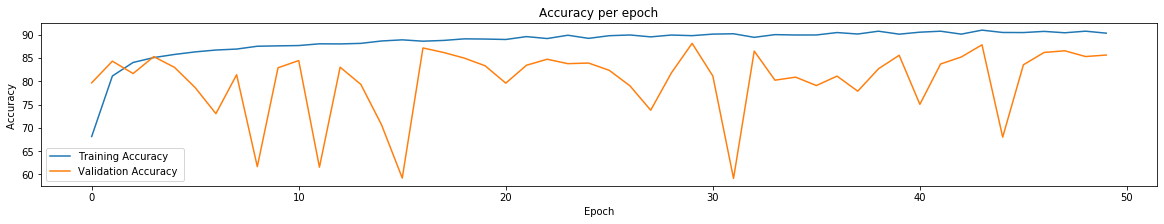

In [0]:
model8.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model8(images) #first pass
            generated_1,predicted_1 = model8(images-generated_0) #feedback loop
            for i in range(3):
                generated_1,predicted_1 = model8(images-generated_1)
                loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss1+loss2*0.7
            test_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}, test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

In [0]:
#CURRENTLY NOT IN USE
plt.rcParams["figure.figsize"] = (20,3)
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model6(test_images) #first pass
generated_1,predicted_1 = model6(test_images-generated_0) #feedback loop
generated_2,predicted_2 = model6(test_images-generated_1)
for i in range(15):
    generated_1,predicted_1 = subtract(images,generated_1)
_, predicted_label = torch.max(predicted_1, 1)

inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)
#inp_model1 = (test_images-generated_0).view(-1,28,28)
#inp_model2 = (test_images-generated_1).view(-1,28,28)
#inp_model3 = (test_images-generated_2).view(-1,28,28)
#inp_model4 = (test_images-generated_3).view(-1,28,28)
#inp_model5 = (test_images-generated_4).view(-1,28,28)
#gen2 = generated_2.view(-1,28,28)
#gen1 = generated_1.view(-1,28,28)
#gen0 = generated_0.view(-1,28,28)
#gen3 = generated_3.view(-1,28,28)
#gen4 = generated_4.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 8, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1,8,2)
    plot.set_title("Output from first pass")
    imgplot = plt.imshow(gen2[i].cpu().detach(),cmap='gray')
    plot = fig.add_subplot(1,8,3)
    plot.set_title("Input to second pass")
    imgplot = plt.imshow(inp_model3[i].cpu().detach(),cmap='gray')
    plot = fig.add_subplot(1,8,4)
    plot.set_title("Output from second pass")
    imgplot = plt.imshow(gen3[i].cpu().detach(),cmap='gray')
    plot = fig.add_subplot(1,8,5)
    plot.set_title("Input to third pass")
    imgplot = plt.imshow(inp_model4[i].cpu().detach(),cmap='gray')
    plot = fig.add_subplot(1,8,6)
    plot.set_title("Output from third pass")
    imgplot = plt.imshow(gen4[i].cpu().detach(),cmap='gray')
    plot = fig.add_subplot(1,8,7)
    plot.set_title("Input to final pass")
    imgplot = plt.imshow(inp_model5[i].cpu().detach(),cmap='gray')
    plot = fig.add_subplot(1, 8, 8)
    plot.set_title('Final Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    
    plt.show()

In [0]:
#CURRENTLY NOT IN USE
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model6.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model6(images) #first pass
            generated_1,predicted_1 = model6(images-generated_0*0.3) #feedback loop
            generated_2,predicted_2 = model6(images-generated_1*0.4)
            generated_3,predicted_3 = model6(images-generated_2*0.5)
            loss1 = criterion1(generated_3,images)
            loss2 = criterion2(predicted_3,labels)
            loss = loss1+loss2
            test_epoch_loss += loss.item()
            pred = predicted_3.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}, test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))


In [0]:
#NOT CURRENTLY IN USE
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model6(test_images) #first pass
generated_1,predicted_1 = model6(test_images-generated_0*0.3) #feedback loop
generated_2,predicted_2 = model6(test_images-generated_0*0.3-generated_1*0.4)
test_output,predicted_3 = model6(test_images-generated_0*0.3-generated_1*0.4-generated_2*0.5)
_, predicted_label = torch.max(predicted_3, 1)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

In [0]:
#NOT CURRENTLY IN USE

model6 = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model6.parameters(),lr=0.01)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model6.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        generated_0,predicted_0 = model6(images) #first pass
        generated_1,predicted_1 = model6(images-generated_0*0.3) #feedback loop - subtract output from input
        generated_2,predicted_2 = model6(images-generated_0*0.3-generated_1*0.4)
        generated_3,predicted_3 = model6(images-generated_0*0.3-generated_1*0.4-generated_2*0.5)
        loss1 = criterion1(generated_3,images)
        loss2 = criterion2(predicted_3,labels)
        loss = loss1+loss2
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted_3.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model6.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model6(images) #first pass
            generated_1,predicted_1 = model6(images-generated_0*0.3) #feedback loop
            generated_2,predicted_2 = model6(images-generated_0*0.3-generated_1*0.4)
            generated_3,predicted_3 = model6(images-generated_0*0.3-generated_1*0.4-generated_2*0.5)
            loss1 = criterion1(generated_3,images)
            loss2 = criterion2(predicted_3,labels)
            loss = loss1+loss2
            val_epoch_loss += loss.item()
            pred = predicted_3.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

In [0]:
#NOT IN USE
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model6.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model6(images) #first pass
            generated_1,predicted_1 = model6(images-generated_0*0.3) #feedback loop
            generated_2,predicted_2 = model6(images-generated_0*0.3-generated_1*0.4)
            generated_3,predicted_3 = model6(images-generated_0*0.3-generated_1*0.4-generated_2*0.5)
            loss1 = criterion1(generated_3,images)
            loss2 = criterion2(predicted_3,labels)
            loss = loss1+loss2
            test_epoch_loss += loss.item()
            pred = predicted_3.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}, test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))
